In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core import display as ICD
import seaborn as sns
pd.set_option('display.max_columns', 100)
from helpers import *

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [3]:
DATA_FOLDER = './' # '../data/'

### Regression matrix manipulation

Importing regression matrix

In [4]:
tot_df=pd.read_csv(DATA_FOLDER+'regression_mat_year.csv',index_col=0)

Transform absolute value and direction in vector components

In [5]:
tot_df=vectorize_wind_speed(tot_df)

In [6]:
tot_df.shape

(535470, 23)

Shorten the matrix for developping purposes

In [9]:
tot_df_small=tot_df
tot_df_small.shape

(535470, 23)

### Splitting Data pandas

In [10]:
tot_df_small_tr, tot_df_small_te=split_data(tot_df_small,0.3)

In [11]:
tot_df_tr, tot_df_te=split_data(tot_df,0.3)

### Standardize the features pandas

In [12]:
# for trying small dataset and debugging purposes
X_small_tr_standard=(tot_df_small_tr.drop(columns=['u_x', 'u_y','u_z'])-tot_df_small_tr.drop(columns=['u_x', 'u_y','u_z']).mean(axis=0))/tot_df_small_tr.drop(columns=['u_x', 'u_y','u_z']).std(axis=0)

In [13]:
X_tr_standard=(tot_df_tr.drop(columns=['u_x', 'u_y','u_z'])-tot_df_tr.drop(columns=['u_x', 'u_y','u_z']).mean(axis=0))/tot_df_tr.drop(columns=['u_x', 'u_y','u_z']).std(axis=0)

In [14]:
y_tr_small=tot_df_small_tr[['u_x','u_y']]

In [15]:
y_tr=tot_df_tr[['u_x','u_y']]

In [16]:
# for trying small dataset and debugging purposes
X_small_te_standard=(tot_df_small_te.drop(columns=['u_x', 'u_y','u_z'])-tot_df_small_te.drop(columns=['u_x', 'u_y','u_z']).mean(axis=0))/tot_df_small_te.drop(columns=['u_x', 'u_y','u_z']).std(axis=0)

In [17]:
X_te_standard=(tot_df_te.drop(columns=['u_x', 'u_y','u_z'])-tot_df_te.drop(columns=['u_x', 'u_y','u_z']).mean(axis=0))/tot_df_te.drop(columns=['u_x', 'u_y','u_z']).std(axis=0)

In [18]:
X_te_standard.shape

(374829, 20)

In [19]:
y_te_small=tot_df_small_te[['u_x','u_y']]

In [20]:
y_te=tot_df_te[['u_x','u_y']]

# Stepwise feature selection for one year

A method to define the most important number of features is backward selection: in this case at the beginning all the features are considered to be important. From a physical point of view, however, it is clear that the free stream wind speed `u_top_x`, `u_top_y` and `h` are going to be important. As a consequence forward feature selection will be implemented. The null hypothesis is that the true regression matrix is only composed by the three columns chosen and at every step a column will be added if the improvement in the value of $R^2$ is more unlikly than the significant level chosen. Then Bidirectional elimination is also implemented: consequently a backward step will be implemented to check if the new column added has a strong covariance with one the previous added columns. In this way the order to addition of the columns won't matter.

In [41]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.005, 
                       threshold_out = 0.1, 
                       verbose=True):
    
    # the threshold in is specified at 0.01 confidence level for the output meaning that for each\
    # velocity component is going to be 0.005 using bonferroni method
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        
        # make a new series with a set of index being the columns you start with
        new_pval = pd.Series(index=excluded)
        
        for new_column in excluded:
            # make the model by adding a column. N.B the order to addition of columns doesn't matter since 
            # all parameters are added one by one and then the most unlikely is selected on the base that the
            # hypothesis of having the estimators being B=0
            
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            # the parameter used to calculate a two tail relative significance level can be obtained
            #based on the R square value of the regression and the 
            
            new_pval[new_column] = model.pvalues[new_column]
        
        # add the column which produced the most unluckily p value
        best_pval = new_pval.min()
        
        # here it starts the backward step. this is useful to contract the order of selection of the features
        # the order of selection matters so the features will only be kept if their removal is significant
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
                
        print ('eigenvalues are', np.linalg.eig(X[included].T@X[included])[0])
        
        print ('the condition number of the matrix is', np.sqrt(np.max(np.linalg.eig(X[included].T@X[included])[0])/np.min(np.linalg.eig(X[included].T@X[included])[0])))
        print ('the set of condition indices of the matrix are', np.sqrt(np.max(np.linalg.eig(X[included].T@X[included])[0])/np.linalg.eig(X[included].T@X[included])[0]))

        # plot the heatmap
        sns.heatmap(pd.DataFrame(X[included]).corr(), 
        xticklabels=pd.DataFrame(X[included]).corr().columns,
        yticklabels=pd.DataFrame(X[included]).corr().columns)
        
        plt.show()


        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        reg = LinearRegression().fit(X[included], y)
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
                model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
                reg = LinearRegression().fit(X[included], y)
  
        if not changed:
            break
    return included

Perform the stepwise feature selection for the x component of velocity of u and visualize the correlation matrix at each iteration. The eigenvalues of the matrix are also visualized since they give an indication of the multicollinearity of the data as well as the condition number.

Add  North temperature [°C]         with p-value 0.0
eigenvalues are [109871.18489328 179586.72257726 192466.165297   160635.92723279]
the condition number of the matrix is 1.3235345802386316
the set of condition indices of the matrix are [1.32353458 1.03523771 1.         1.09460104]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


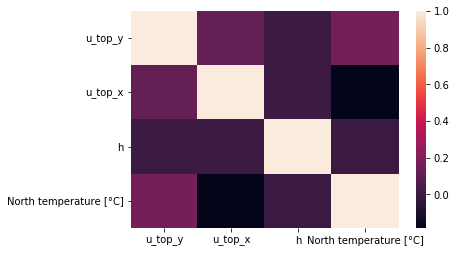

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  sonic_temp                     with p-value 0.0
eigenvalues are [322169.03489776  11351.88720881 129394.34426498 179627.44934767
 160657.28428111]
the condition number of the matrix is 5.3273087113232975
the set of condition indices of the matrix are [1.         5.32730871 1.57791735 1.33923116 1.41609271]


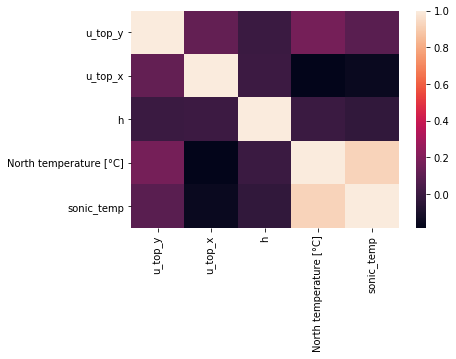

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Radiometer Ground temperature [°C] with p-value 2.85129e-296
eigenvalues are [476157.89827483  13930.30758026   3345.60277324 129945.20629143
 179752.16263944 160708.82244112]
the condition number of the matrix is 11.929941349025192
the set of condition indices of the matrix are [ 1.          5.84648909 11.92994135  1.91423549  1.62756535  1.72129631]


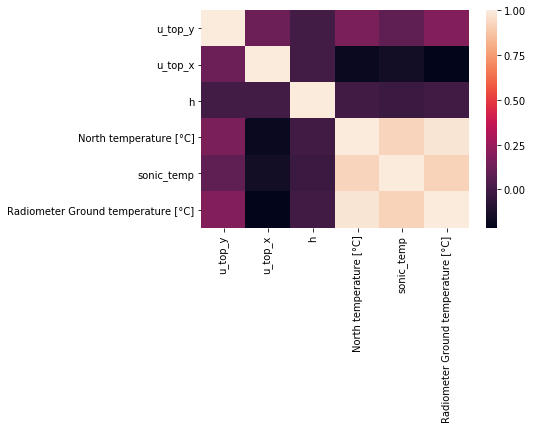

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  u_top_z                        with p-value 2.51517e-88
eigenvalues are [476584.90886095  13570.70612829   3342.71605467 195953.27659598
 129935.94339355 144383.55627084 160708.89269606]
the condition number of the matrix is 11.940441892794043
the set of condition indices of the matrix are [ 1.          5.92609924 11.94044189  1.55953052  1.91516189  1.81681738
  1.72206757]


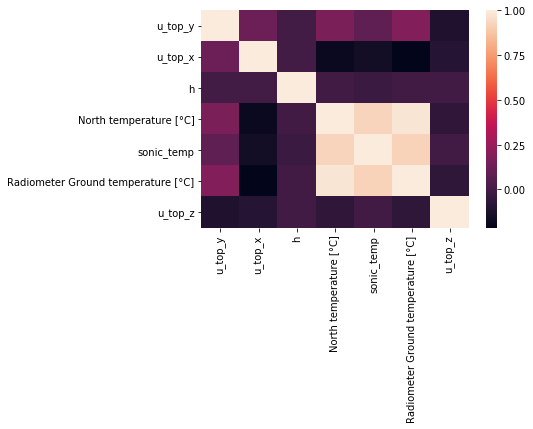

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  West temperature [°C]          with p-value 1.05883e-85
eigenvalues are [628588.31968478  14700.21409554   6536.32927585   3135.49913798
 196034.00453062 130979.16584549 144420.94692362 160725.52050645]
the condition number of the matrix is 14.158909651944201
the set of condition indices of the matrix are [ 1.          6.53915036  9.80654876 14.15890965  1.79067779  2.19069564
  2.08625821  1.97761038]


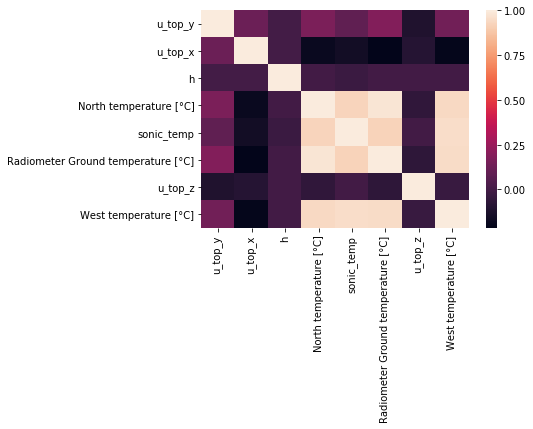

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Sky temperature [°C]           with p-value 1.54536e-36
eigenvalues are [726030.71790103 199980.92391157  58593.70497332  12621.7244101
   3135.49597956   6446.45249852 133421.06204429 144792.37320489
 160737.54507704]
the condition number of the matrix is 15.216836482369645
the set of condition indices of the matrix are [ 1.          1.90538707  3.52007582  7.58434624 15.21683648 10.61248537
  2.33273444  2.23926068  2.1252931 ]


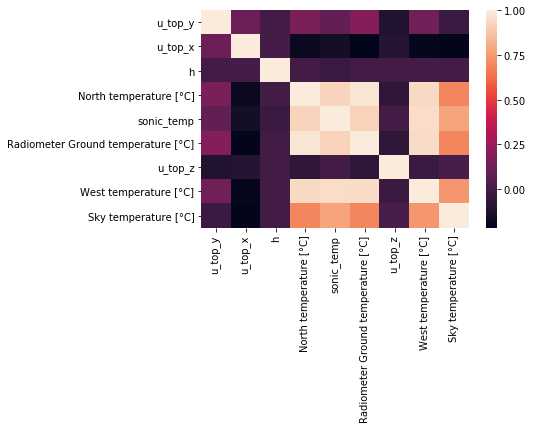

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  South temperature [°C]         with p-value 1.08952e-58
eigenvalues are [882374.14684449 200037.05331959 134095.10497134 144857.0546335
 160741.55252358  58955.80254651  13696.10233826   6675.17203759
   3658.5116021    1309.49918336]
the condition number of the matrix is 25.958152022969394
the set of condition indices of the matrix are [ 1.          2.10025082  2.56519229  2.46806482  2.34294616  3.86868268
  8.02653107 11.49728127 15.53009703 25.95815202]


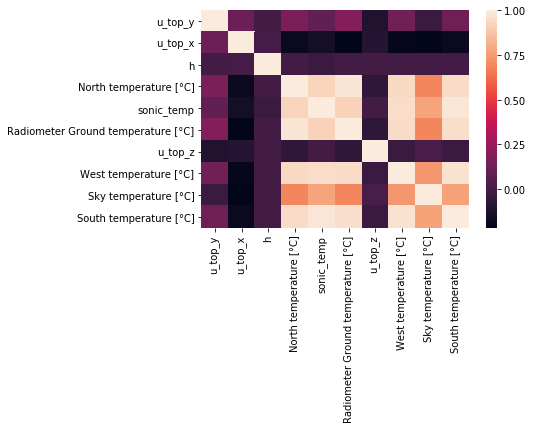

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  sonic_temp_top                 with p-value 1.48312e-11
eigenvalues are [1.03396247e+06 2.00049520e+05 1.35935972e+05 1.45205101e+05
 1.60743374e+05 5.90529963e+04 1.89171871e+04 7.65658983e+03
 3.76582477e+03 3.50932102e+02 1.40003484e+03]
the condition number of the matrix is 54.28012490209242
the set of condition indices of the matrix are [ 1.          2.2734407   2.75794238  2.66846463  2.53621371  4.1843829
  7.39305791 11.62076439 16.56999333 54.2801249  27.17583932]


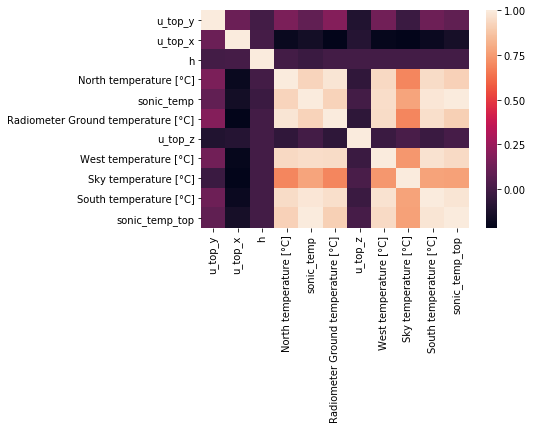

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Sensor Ground temperature [°C] with p-value 4.13623e-10
eigenvalues are [1.17448942e+06 2.00888567e+05 1.36405977e+05 1.45208085e+05
 1.60746447e+05 6.15901296e+04 2.37620891e+04 1.35005346e+04
 7.25491363e+03 2.18987680e+03 3.50930370e+02 1.29303274e+03]
the condition number of the matrix is 57.85142711384736
the set of condition indices of the matrix are [ 1.          2.41794793  2.93432257  2.84399713  2.70304866  4.36685725
  7.03043575  9.32715234 12.72355381 23.1587286  57.85142711 30.13837232]


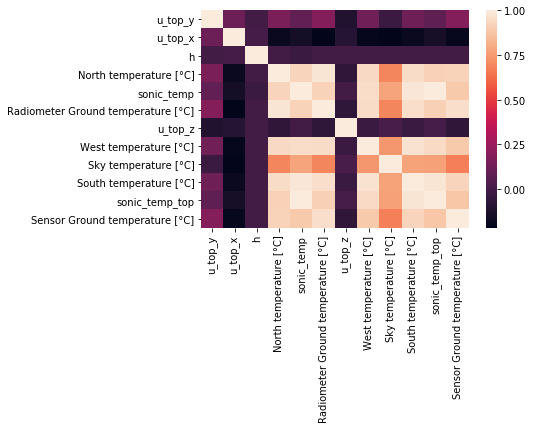

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Pyrgeometer Lower Irradiance [W/m$^2$] with p-value 0.000642321
eigenvalues are [1.32513879e+06 2.01684859e+05 1.37124077e+05 1.45219927e+05
 1.60749083e+05 6.52761035e+04 2.71011364e+04 1.40506256e+04
 7.25861162e+03 2.58721432e+03 1.62959536e+03 3.50960613e+02
 1.49011190e+02]
the condition number of the matrix is 94.30207371669343
the set of condition indices of the matrix are [ 1.          2.56326812  3.1086643   3.02076943  2.87115364  4.50560975
  6.99257178  9.71142259 13.51151054 22.63155948 28.51614372 61.44711464
 94.30207372]


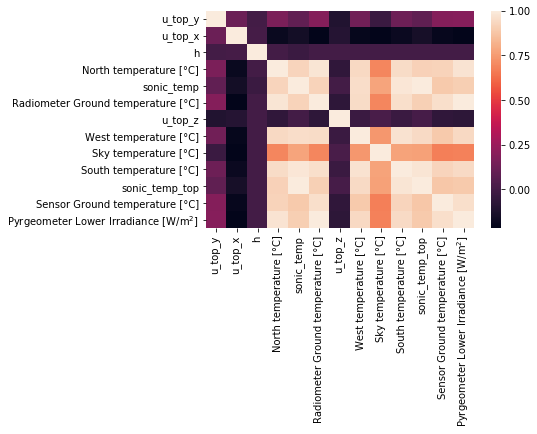

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:76: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Drop Radiometer Ground temperature [°C] with p-value 0.69326
eigenvalues are [1.17172135e+06 2.01106414e+05 1.36635128e+05 1.45215207e+05
 1.60746658e+05 6.21290570e+04 2.53768782e+04 1.35858042e+04
 7.25486870e+03 3.49641818e+02 2.06487799e+03 1.49411057e+03]
the condition number of the matrix is 57.88959184518248
the set of condition indices of the matrix are [ 1.          2.41378848  2.92840398  2.8405741   2.6998597   4.34274962
  6.79505654  9.28687279 12.70859074 57.88959185 23.82127348 28.00404733]


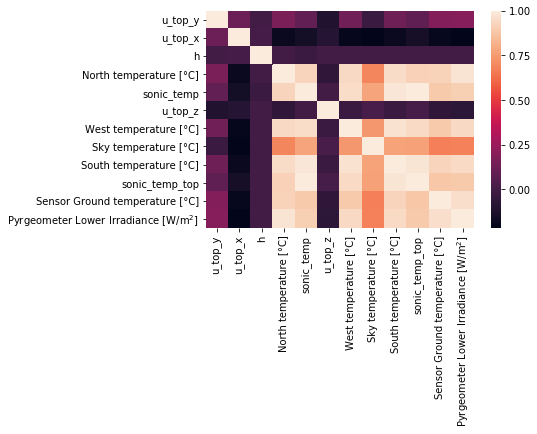

resulting features:
['u_top_y', 'u_top_x', 'h', 'North temperature [°C]', 'sonic_temp', 'u_top_z', 'West temperature [°C]', 'Sky temperature [°C]', 'South temperature [°C]', 'sonic_temp_top', 'Sensor Ground temperature [°C]', 'Pyrgeometer Lower Irradiance [W/m$^2$]']


In [42]:
result = stepwise_selection(X_small_tr_standard, y_tr_small.iloc[:,0], initial_list=['u_top_y', 'u_top_x','h'])

print('resulting features:')
print(result)

Perform the stepwise feature selection for the y component of velocity of u and visualize the correlation matrix at each iteration. The eigenvalues of the matrix are also visualized since they give an indication of the multicollinearity of the data as well as the condition number.

Add  u_top_z                        with p-value 2.15848e-33
eigenvalues are [195612.75679095 140849.59277419 145455.86266589 160641.78776929]
the condition number of the matrix is 1.1784761263876604
the set of condition indices of the matrix are [1.         1.17847613 1.15966613 1.10349234]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


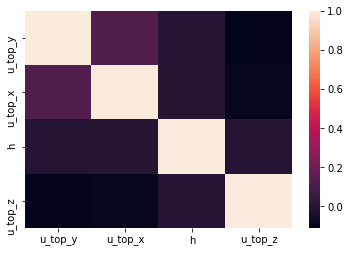

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Net Far Infrared radiation [W/m$^2$] with p-value 2.63548e-33
eigenvalues are [101413.6963621  218212.34271619 144488.63524988 178458.72321489
 160626.60245727]
the condition number of the matrix is 1.4668690650221121
the set of condition indices of the matrix are [1.46686907 1.         1.22891773 1.10578518 1.16555003]


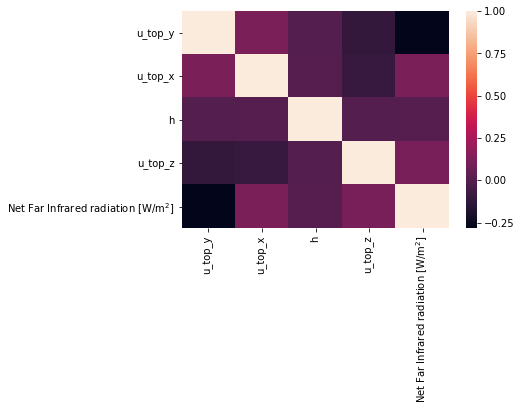

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Net (total) radiation [W/m$^2$] with p-value 3.71178e-59
eigenvalues are [303524.84942825  54755.78070019 106765.87486754 193230.1867888
 144926.97913378 160636.32908178]
the condition number of the matrix is 2.354410242592946
the set of condition indices of the matrix are [1.         2.35441024 1.68609055 1.25331327 1.44717985 1.37459652]


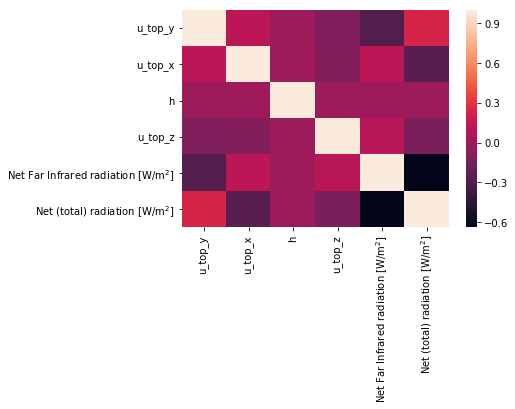

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Sensor Ground temperature [°C] with p-value 1.22336e-28
eigenvalues are [398558.26149704  32954.93922272  74538.03083353 195060.21222008
 117226.71194036 145504.12270429 160637.7215823 ]
the condition number of the matrix is 3.477648231006404
the set of condition indices of the matrix are [1.         3.47764823 2.312368   1.42942562 1.84387984 1.6550391
 1.57515081]


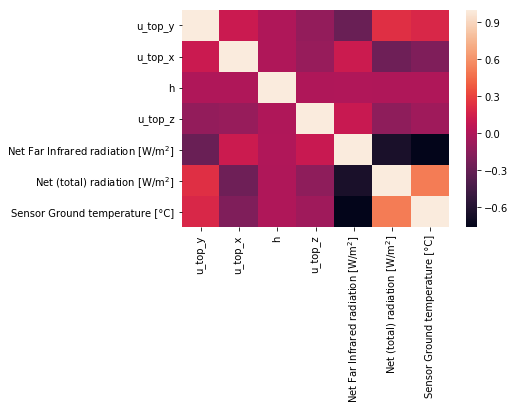

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  North temperature [°C]         with p-value 1.7022e-23
eigenvalues are [523567.67032416  12230.55814238  37340.64701806  80208.95853766
 196391.83405419 128630.4517669  146110.86823768 160639.01191928]
the condition number of the matrix is 6.542794387999845
the set of condition indices of the matrix are [1.         6.54279439 3.74451428 2.55490627 1.63276882 2.01750451
 1.89297618 1.80534787]


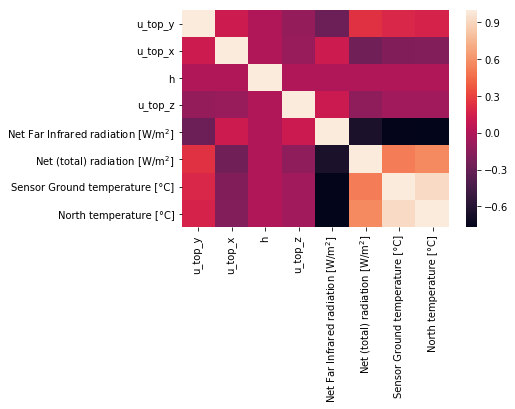

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Sky temperature [°C]           with p-value 3.39554e-44
eigenvalues are [574908.69899438 216852.65852929  12321.44629741   1781.73946242
  68667.28195927 111406.58327754 146108.44859548 153046.37017335
 160666.77271118]
the condition number of the matrix is 17.962936743881095
the set of condition indices of the matrix are [ 1.          1.62823492  6.83075322 17.96293674  2.89350683  2.27166357
  1.98363506  1.9381524   1.89163092]


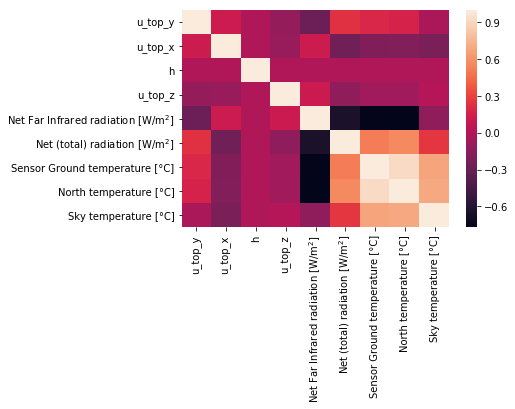

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:76: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Drop Sensor Ground temperature [°C] with p-value 0.210017


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Pyranometer Lower Irradiance [W/m$^2$] with p-value 2.96997e-30
eigenvalues are [549722.25540724 221590.09282067   5463.69364902   2532.29118043
  79281.99157039 115126.64637534 145949.31365933 165480.42719167
 160613.28814622]
the condition number of the matrix is 14.733802316320116
the set of condition indices of the matrix are [ 1.          1.57505778 10.03063644 14.73380232  2.63320326  2.18516247
  1.94075463  1.82262928  1.85003917]


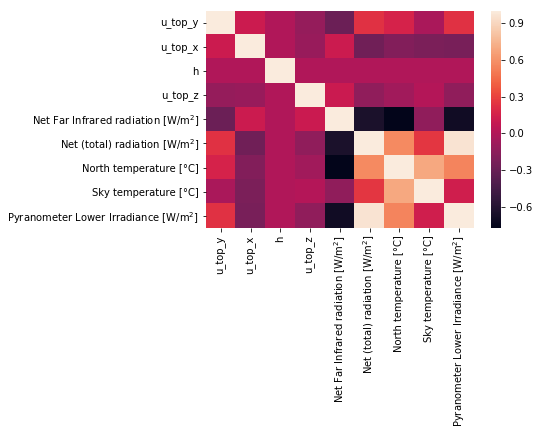

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  East temperature [°C]          with p-value 2.04665e-06
eigenvalues are [677236.79311824 231736.2867286  174555.19908141 115660.75920905
 146482.27546027 160631.99294961  81788.49340201  11651.64860698
   4557.00612      2099.54532415]
the condition number of the matrix is 17.96005428688078
the set of condition indices of the matrix are [ 1.          1.70951632  1.9697172   2.41978763  2.15019443  2.05330871
  2.87755854  7.62388932 12.19075116 17.96005429]


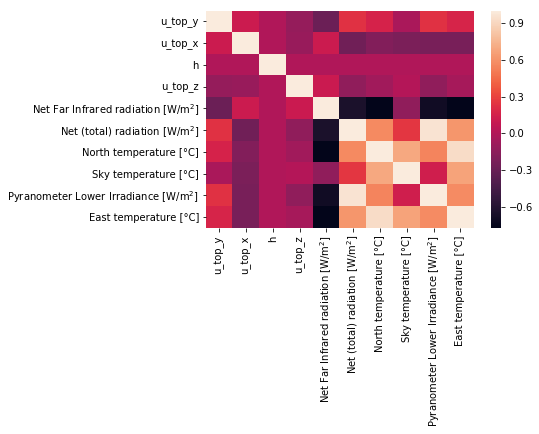

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  sonic_temp                     with p-value 4.59873e-06
eigenvalues are [779594.35383048 267374.45757857 188846.40347943 146637.9877678
 115703.70015252 160704.20963069  85184.7153924   11661.22650825
   1791.77261533   5027.75266099   4513.42038386]
the condition number of the matrix is 20.85897171429129
the set of condition indices of the matrix are [ 1.          1.70755375  2.03179545  2.30574405  2.59573719  2.20252434
  3.02519591  8.17640183 20.85897171 12.45223736 13.14260482]


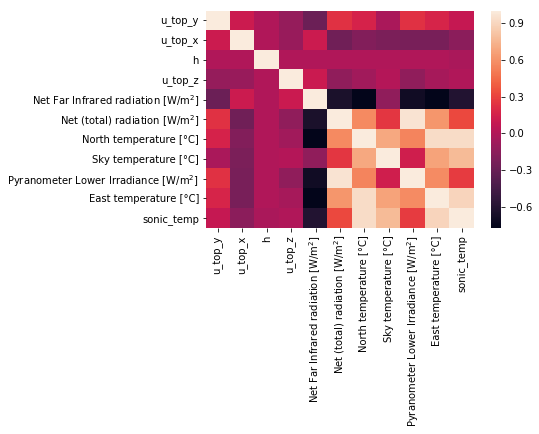

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  sonic_temp_top                 with p-value 3.13838e-77
eigenvalues are [8.98131096e+05 3.00118380e+05 1.93447894e+05 1.46740363e+05
 1.60727878e+05 1.15726701e+05 8.70407374e+04 1.16942671e+04
 7.32656843e+03 4.55970768e+03 3.49321351e+02 1.81708549e+03]
the condition number of the matrix is 50.70576055146373
the set of condition indices of the matrix are [ 1.          1.72991024  2.15470522  2.47397366  2.36387366  2.78582019
  3.21224444  8.76361645 11.07183389 14.03464288 50.70576055 22.23218697]


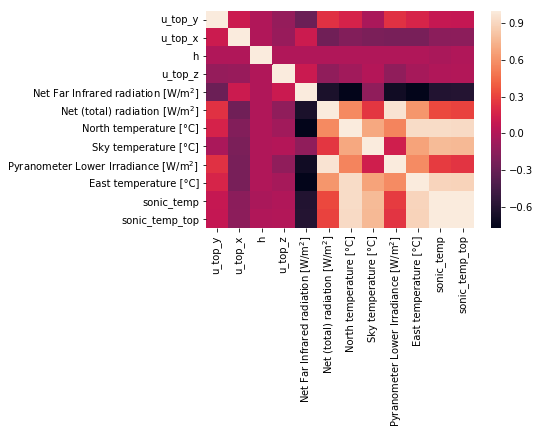

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:76: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Drop h                              with p-value 0.245042


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  West temperature [°C]          with p-value 1.29486e-06
eigenvalues are [1.04667236e+06 3.05576708e+05 1.93764840e+05 1.46742841e+05
 1.15765759e+05 8.70503001e+04 1.24284871e+04 9.63995776e+03
 4.58862057e+03 3.40410324e+03 4.11488470e+02 1.63453858e+03]
the condition number of the matrix is 50.434363241925716
the set of condition indices of the matrix are [ 1.          1.85073933  2.32417     2.67071112  3.00687459  3.46753011
  9.17690517 10.42000223 15.1030376  17.53492915 50.43436324 25.30508432]


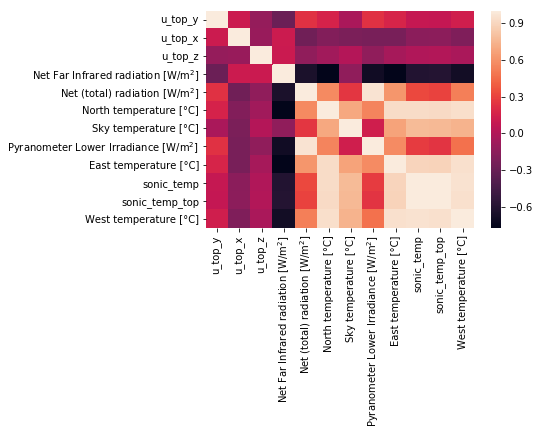

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Radiometer Ground temperature [°C] with p-value 0.000103304
eigenvalues are [1.20402688e+06 3.05738541e+05 1.94017545e+05 1.46760129e+05
 1.15891212e+05 8.74220014e+04 1.29494562e+04 1.08435340e+04
 4.93746203e+03 3.40412420e+03 1.40886205e+02 4.11698271e+02
 1.77652934e+03]
the condition number of the matrix is 92.44509150707133
the set of condition indices of the matrix are [ 1.          1.98446296  2.49113687  2.86427063  3.22324144  3.71114326
  9.64255948 10.53738066 15.6158708  18.80682107 92.44509151 54.07898975
 26.0334604 ]


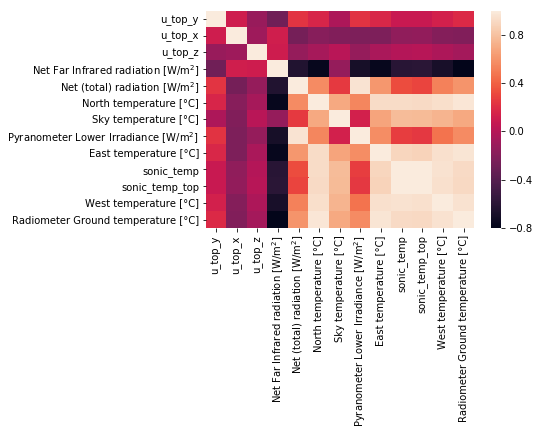

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:76: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Drop Net Far Infrared radiation [W/m$^2$] with p-value 0.292728


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  South temperature [°C]         with p-value 0.000134724
eigenvalues are [1.26298266e+06 2.88567406e+05 1.93272322e+05 1.44609191e+05
 1.11873730e+05 5.40593005e+04 1.22094306e+04 9.66194849e+03
 4.09415733e+02 9.63484881e+02 4.16636894e+03 2.08978745e+03
 3.45495029e+03]
the condition number of the matrix is 55.54134991525493
the set of condition indices of the matrix are [ 1.          2.09206444  2.55631202  2.95529437  3.35996409  4.8335196
 10.17070339 11.43316144 55.54134992 36.20564115 17.41084433 24.58372204
 19.11955557]


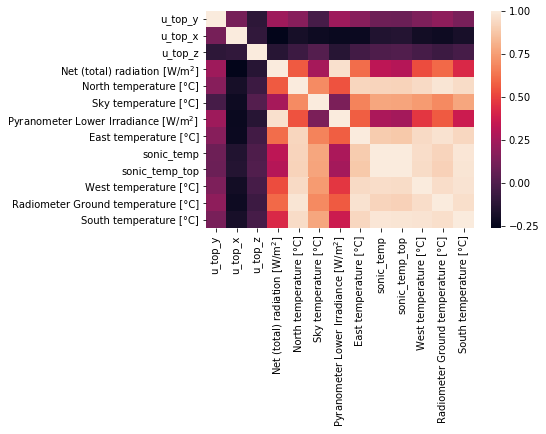

eigenvalues are [1.26298266e+06 2.88567406e+05 1.93272322e+05 1.44609191e+05
 1.11873730e+05 5.40593005e+04 1.22094306e+04 9.66194849e+03
 4.09415733e+02 9.63484881e+02 4.16636894e+03 2.08978745e+03
 3.45495029e+03]
the condition number of the matrix is 55.54134991525493
the set of condition indices of the matrix are [ 1.          2.09206444  2.55631202  2.95529437  3.35996409  4.8335196
 10.17070339 11.43316144 55.54134992 36.20564115 17.41084433 24.58372204
 19.11955557]


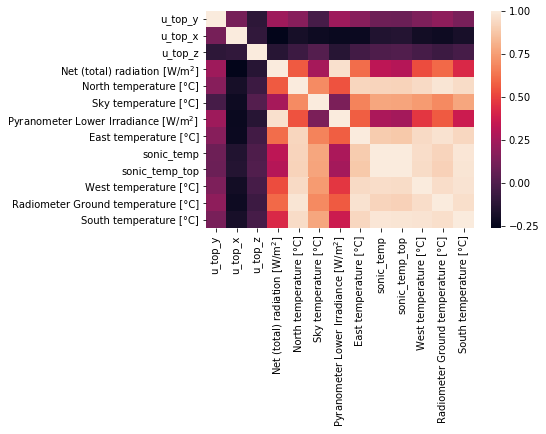

resulting features:
['u_top_y', 'u_top_x', 'u_top_z', 'Net (total) radiation [W/m$^2$]', 'North temperature [°C]', 'Sky temperature [°C]', 'Pyranometer Lower Irradiance [W/m$^2$]', 'East temperature [°C]', 'sonic_temp', 'sonic_temp_top', 'West temperature [°C]', 'Radiometer Ground temperature [°C]', 'South temperature [°C]']


In [43]:
result = stepwise_selection(X_small_tr_standard, y_tr_small.iloc[:,1], initial_list=['u_top_y', 'u_top_x','h'])

print('resulting features:')
print(result)

# Stepwise feature selection for each season

Splitting the data into seasons

In [44]:
df_spring, df_summer, df_autumn, df_winter=season_splitter(tot_df)

In [45]:
df_spring_tr, df_spring_te=split_data(df_spring,0.3)
df_summer_tr, df_summer_te=split_data(df_summer,0.3)
df_autumn_tr, df_autumn_te=split_data(df_autumn,0.3)
df_winter_tr, df_winter_te=split_data(df_winter,0.3)

Standardizing the data and setting the input and output variables

In [46]:
X_spring_tr_standard=(df_spring_tr.drop(columns=['u_x', 'u_y','u_z'])-df_spring_tr.drop(columns=['u_x', 'u_y','u_z']).mean(axis=0))/df_spring_tr.drop(columns=['u_x', 'u_y','u_z']).std(axis=0)
X_autumn_tr_standard=(df_autumn_tr.drop(columns=['u_x', 'u_y','u_z'])-df_autumn_tr.drop(columns=['u_x', 'u_y','u_z']).mean(axis=0))/df_autumn_tr.drop(columns=['u_x', 'u_y','u_z']).std(axis=0)
X_summer_tr_standard=(df_summer_tr.drop(columns=['u_x', 'u_y','u_z'])-df_summer_tr.drop(columns=['u_x', 'u_y','u_z']).mean(axis=0))/df_summer_tr.drop(columns=['u_x', 'u_y','u_z']).std(axis=0)
X_winter_tr_standard=(df_winter_tr.drop(columns=['u_x', 'u_y','u_z'])-df_winter_tr.drop(columns=['u_x', 'u_y','u_z']).mean(axis=0))/df_winter_tr.drop(columns=['u_x', 'u_y','u_z']).std(axis=0)

In [47]:
y_spring_tr=df_spring_tr[['u_x','u_y']]
y_summer_tr=df_summer_tr[['u_x','u_y']]
y_autumn_tr=df_autumn_tr[['u_x','u_y']]
y_winter_tr=df_winter_tr[['u_x','u_y']]

In [48]:
X_spring_te_standard=(df_spring_te.drop(columns=['u_x', 'u_y','u_z'])-df_spring_te.drop(columns=['u_x', 'u_y','u_z']).mean(axis=0))/df_spring_te.drop(columns=['u_x', 'u_y','u_z']).std(axis=0)
X_autumn_te_standard=(df_autumn_te.drop(columns=['u_x', 'u_y','u_z'])-df_autumn_te.drop(columns=['u_x', 'u_y','u_z']).mean(axis=0))/df_autumn_te.drop(columns=['u_x', 'u_y','u_z']).std(axis=0)
X_summer_te_standard=(df_summer_te.drop(columns=['u_x', 'u_y','u_z'])-df_summer_te.drop(columns=['u_x', 'u_y','u_z']).mean(axis=0))/df_summer_te.drop(columns=['u_x', 'u_y','u_z']).std(axis=0)
X_winter_te_standard=(df_winter_te.drop(columns=['u_x', 'u_y','u_z'])-df_winter_te.drop(columns=['u_x', 'u_y','u_z']).mean(axis=0))/df_winter_te.drop(columns=['u_x', 'u_y','u_z']).std(axis=0)

In [49]:
y_spring_te=df_spring_te[['u_x','u_y']]
y_summer_te=df_summer_te[['u_x','u_y']]
y_autumn_te=df_autumn_te[['u_x','u_y']]
y_winter_te=df_winter_te[['u_x','u_y']]

### Spring

Perform the stepwise feature selection for the x component of velocity of u and visualize the correlation matrix at each iteration. The eigenvalues of the matrix are also visualized since they give an indication of the multicollinearity of the data as well as the condition number.

Add  Net Far Infrared radiation [W/m$^2$] with p-value 0.0
eigenvalues are [24329.35180834 42378.28195394 37082.54094184 34581.82529588]
the condition number of the matrix is 1.3197947724344243
the set of condition indices of the matrix are [1.31979477 1.         1.06902271 1.10700024]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


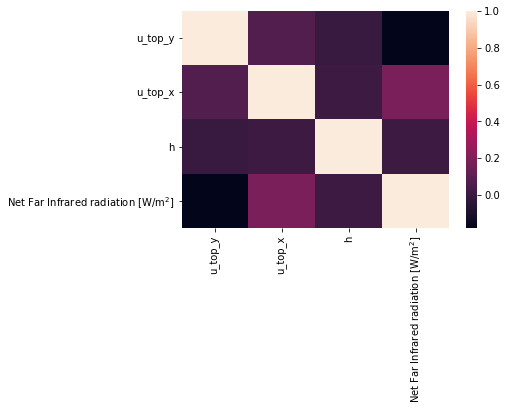

Add  Net (total) radiation [W/m$^2$] with p-value 4.66489e-138
eigenvalues are [65989.26805259  9989.78705018 25246.61794927 37148.48774178
 34590.83920618]
the condition number of the matrix is 2.570150413126317
the set of condition indices of the matrix are [1.         2.57015041 1.6167209  1.33280338 1.38119853]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


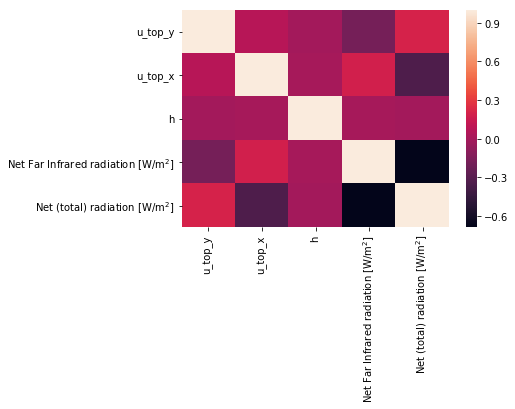

Add  u_top_z                        with p-value 6.08455e-47
eigenvalues are [67093.83011039  9936.31425803 25080.49135246 39570.35868891
 31274.10766973 34602.89792049]
the condition number of the matrix is 2.59853537263071
the set of condition indices of the matrix are [1.         2.59853537 1.63558558 1.30213586 1.4647005  1.39246746]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


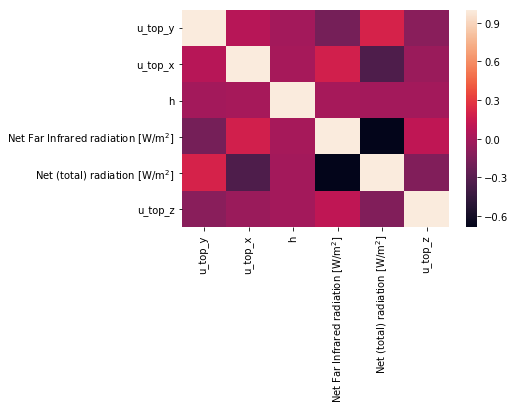

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  sonic_temp                     with p-value 2.5763e-09
eigenvalues are [77241.36859245  8057.32323872 21196.99688675 39836.11384395
 28810.50224251 32011.74626092 34996.94893471]
the condition number of the matrix is 3.0962041378784297
the set of condition indices of the matrix are [1.         3.09620414 1.90892037 1.39247209 1.63738032 1.55335349
 1.48562736]


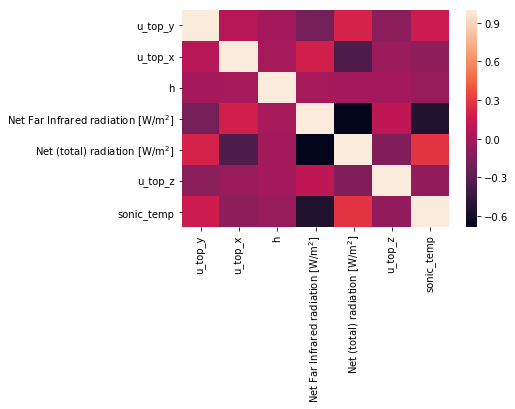

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Radiometer Ground temperature [°C] with p-value 1.45747e-69
eigenvalues are [108186.12932524   1133.58120926   8166.13133302  21435.98466857
  39836.25876246  30007.51623241  35108.62434988  32869.77411917]
the condition number of the matrix is 9.769210607168842
the set of condition indices of the matrix are [1.         9.76921061 3.63980076 2.24653957 1.64795944 1.89876303
 1.75541128 1.81420948]


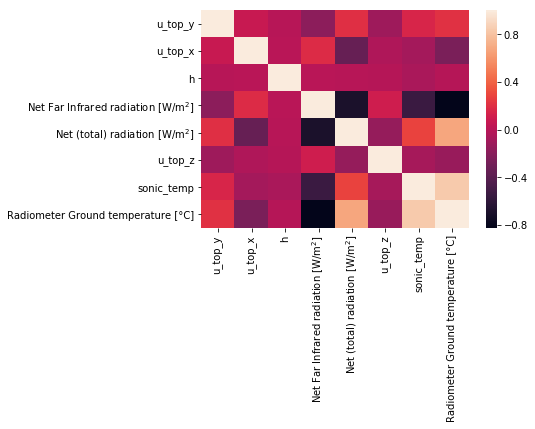

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:76: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Drop Net Far Infrared radiation [W/m$^2$] with p-value 0.677717


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  West temperature [°C]          with p-value 2.4365e-44
eigenvalues are [114662.29483845   1057.46135818   3129.14149827  18817.12988256
  39821.77692664  30348.40135742  35289.80998993  33617.98414855]
the condition number of the matrix is 10.413052585415949
the set of condition indices of the matrix are [ 1.         10.41305259  6.05337688  2.4685028   1.69687557  1.94375895
  1.80254309  1.84681962]


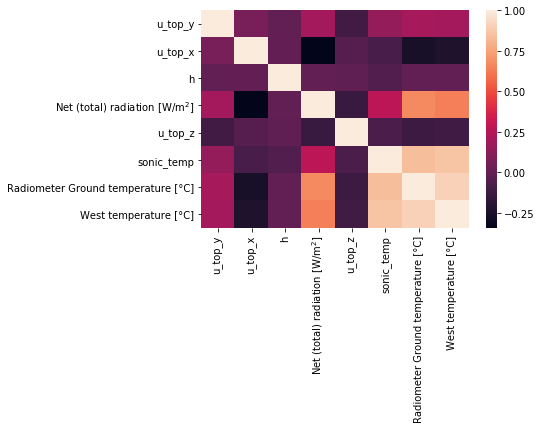

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  East temperature [°C]          with p-value 1.71348e-09
eigenvalues are [147380.86803709  39822.00566149  30393.67099551  35372.70676476
  33875.59314515  18897.8973433    3545.20328907    691.33183988
   1357.72292376]
the condition number of the matrix is 14.600820957681593
the set of condition indices of the matrix are [ 1.          1.92379588  2.20205913  2.04120399  2.08582131  2.79263266
  6.44762816 14.60082096 10.41873471]


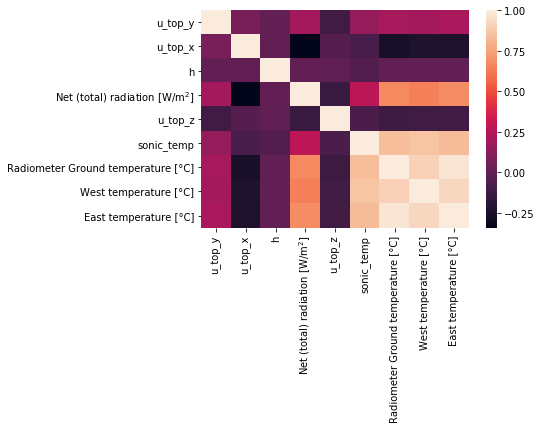

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  South temperature [°C]         with p-value 1.39421e-16
eigenvalues are [178261.15997699  39948.68033803  36536.82820706  30691.3815898
  34434.15770229  19499.55168      3776.82594041   1365.25236671
    607.24585489    808.91634383]
the condition number of the matrix is 17.133499831412426
the set of condition indices of the matrix are [ 1.          2.1124048   2.20883331  2.41001721  2.27527362  3.02354231
  6.8701288  11.42672814 17.13349983 14.84487548]


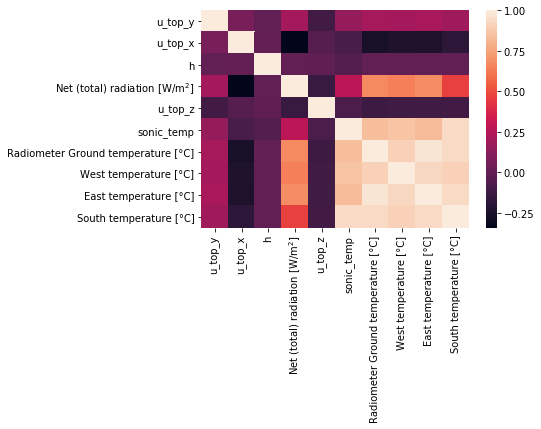

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:76: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Drop Net (total) radiation [W/m$^2$] with p-value 0.23107


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  sonic_temp_top                 with p-value 0.000147081
eigenvalues are [1.93393038e+05 3.94934850e+04 3.00635151e+04 3.30777137e+04
 3.47468231e+04 9.74035289e+03 3.58547199e+03 9.98365570e+02
 6.41819299e+02 1.89415574e+02]
the condition number of the matrix is 31.953068869940886
the set of condition indices of the matrix are [ 1.          2.21287911  2.53629951  2.41797984  2.35918972  4.45587575
  7.3442466  13.91796115 17.35857346 31.95306887]


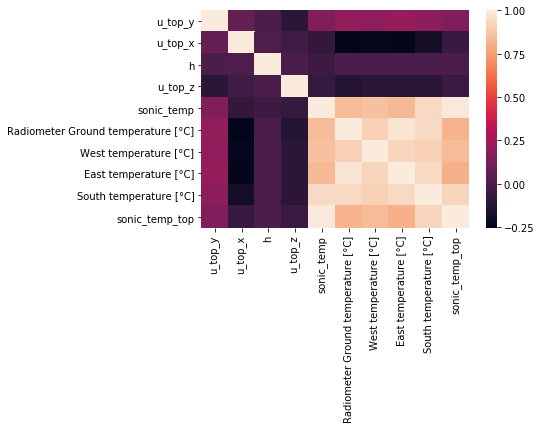

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Sensor Ground temperature [°C] with p-value 8.48581e-05
eigenvalues are [2.22438208e+05 3.95003028e+04 3.01169324e+04 3.31627886e+04
 3.47664473e+04 1.13206382e+04 5.90654173e+03 1.55228856e+03
 1.84939124e+02 5.86428312e+02 9.87485120e+02]
the condition number of the matrix is 34.68089488096337
the set of condition indices of the matrix are [ 1.          2.37303685  2.71768631  2.5898772   2.5294409   4.43270916
  6.13674469 11.97067018 34.68089488 19.47588623 15.00857341]


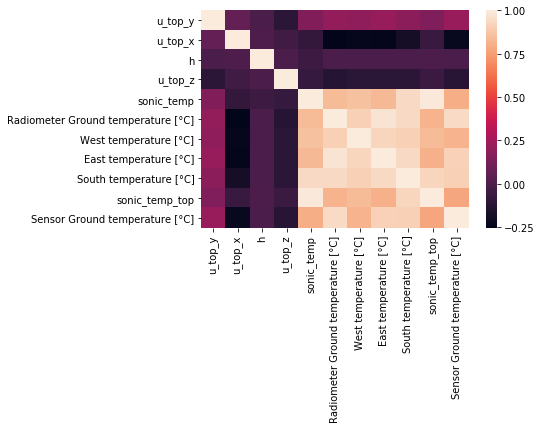

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  North temperature [°C]         with p-value 1.92986e-07
eigenvalues are [2.52751209e+05 3.95503665e+04 3.01187976e+04 3.32272823e+04
 3.47859123e+04 1.20349749e+04 6.37576070e+03 3.79990617e+03
 1.38260766e+03 6.56384016e+02 1.84078930e+02 2.48719318e+02]
the condition number of the matrix is 37.0548091561319
the set of condition indices of the matrix are [ 1.          2.5279668   2.89686199  2.75803143  2.69553467  4.58272742
  6.29623048  8.15568014 13.52063668 19.62310026 37.05480916 31.87805844]


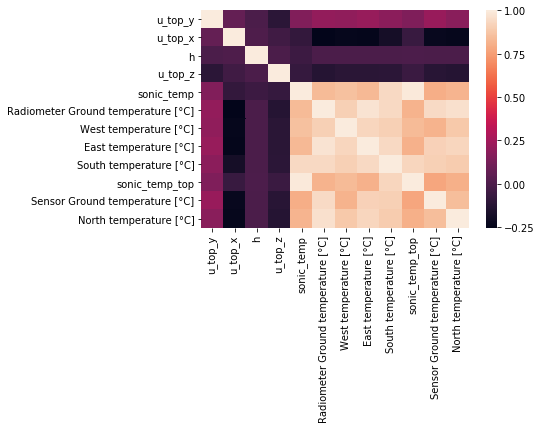

eigenvalues are [2.52751209e+05 3.95503665e+04 3.01187976e+04 3.32272823e+04
 3.47859123e+04 1.20349749e+04 6.37576070e+03 3.79990617e+03
 1.38260766e+03 6.56384016e+02 1.84078930e+02 2.48719318e+02]
the condition number of the matrix is 37.0548091561319
the set of condition indices of the matrix are [ 1.          2.5279668   2.89686199  2.75803143  2.69553467  4.58272742
  6.29623048  8.15568014 13.52063668 19.62310026 37.05480916 31.87805844]


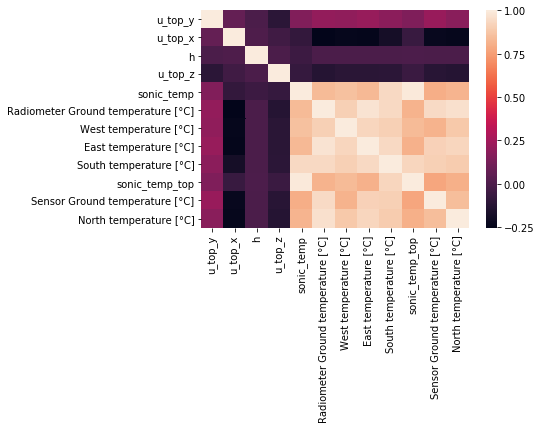

resulting features:
['u_top_y', 'u_top_x', 'h', 'u_top_z', 'sonic_temp', 'Radiometer Ground temperature [°C]', 'West temperature [°C]', 'East temperature [°C]', 'South temperature [°C]', 'sonic_temp_top', 'Sensor Ground temperature [°C]', 'North temperature [°C]']


In [50]:
result = stepwise_selection(X_spring_tr_standard, y_spring_tr.iloc[:,0], initial_list=['u_top_y', 'u_top_x','h'])

print('resulting features:')
print(result)

Perform the stepwise feature selection for the y component of velocity of u and visualize the correlation matrix at each iteration. The eigenvalues of the matrix are also visualized since they give an indication of the multicollinearity of the data as well as the condition number.

Add  Sky temperature [°C]           with p-value 1.64183e-08
eigenvalues are [26380.10248069 40747.07477745 36647.80025914 34597.02248273]
the condition number of the matrix is 1.2428249950505295
the set of condition indices of the matrix are [1.242825   1.         1.0544458  1.08524766]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


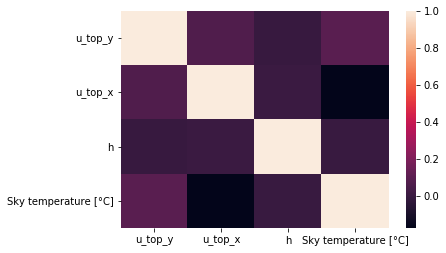

Add  sonic_temp_top                 with p-value 4.11106e-14
eigenvalues are [59458.00353182 11964.85300331 29525.75144631 37416.82298828
 34599.56903028]
the condition number of the matrix is 2.2292125406145935
the set of condition indices of the matrix are [1.         2.22921254 1.41907282 1.26058376 1.31090076]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


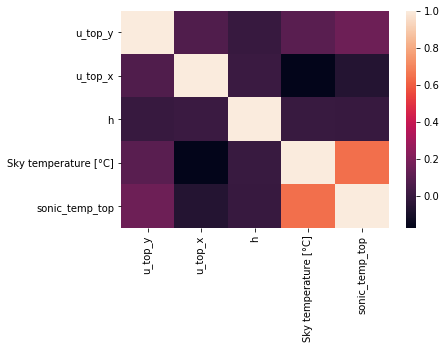

Add  Net Far Infrared radiation [W/m$^2$] with p-value 8.65484e-11
eigenvalues are [66351.36810131  4361.88481866 28053.092198   38041.98239001
 36192.63756412 34557.03492791]
the condition number of the matrix is 3.900208678890419
the set of condition indices of the matrix are [1.         3.90020868 1.53792293 1.32066714 1.35398803 1.38566008]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


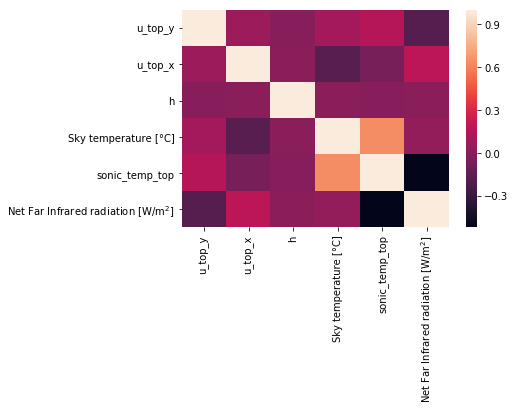

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  North temperature [°C]         with p-value 4.63508e-06
eigenvalues are [96806.74793377  1157.92390672  5546.23151086 28816.44322287
 38331.42275398 36916.09496169 34576.13571011]
the condition number of the matrix is 9.143507073453216
the set of condition indices of the matrix are [1.         9.14350707 4.17785938 1.83287407 1.58918825 1.61936571
 1.67326447]


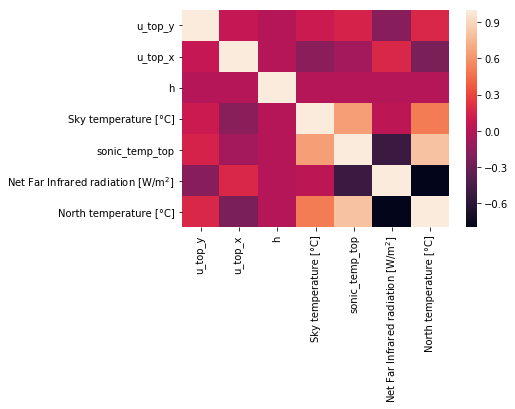

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Pyranometer Lower Irradiance [W/m$^2$] with p-value 3.00878e-05
eigenvalues are [111762.33635253   1151.36310895   1864.62973487  13304.67932488
  47383.15065584  28991.68352048  37694.58567316  34591.57162928]
the condition number of the matrix is 9.852389687403731
the set of condition indices of the matrix are [1.         9.85238969 7.74196909 2.89831464 1.53580391 1.96341009
 1.72190128 1.79747388]


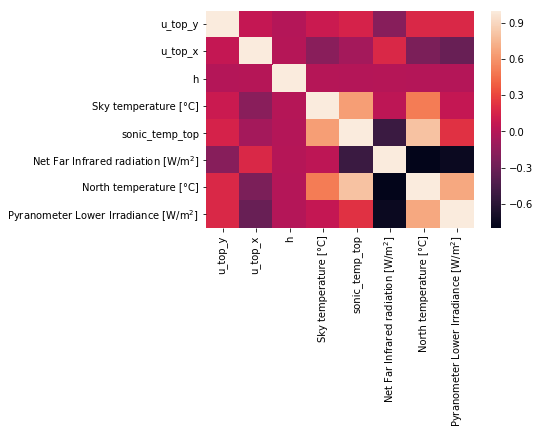

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Net (total) radiation [W/m$^2$] with p-value 2.86421e-06
eigenvalues are [133807.58673695  53578.29033379  37781.04655002  29458.29461355
  34593.1998252   18134.18952304   2327.7851947    1356.81949072
    299.78773204]
the condition number of the matrix is 21.126786366494613
the set of condition indices of the matrix are [ 1.          1.5803233   1.88192962  2.13126066  1.96673117  2.71638481
  7.58174054  9.93068788 21.12678637]


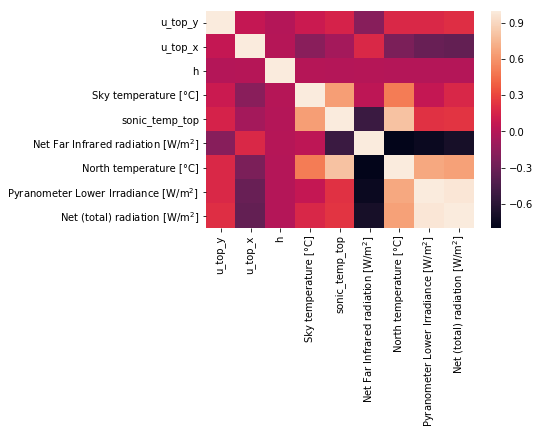

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  East temperature [°C]          with p-value 0.000845914
eigenvalues are [164725.98190391  55263.84163627  37792.71343863  29681.9428134
  34593.21039518  18144.83615303    290.81311344    693.698934
   2566.12190893   2176.83970322]
the condition number of the matrix is 23.799841210254133
the set of condition indices of the matrix are [ 1.          1.72647589  2.0877429   2.35578087  2.18215511  3.01303743
 23.79984121 15.40974808  8.01202711  8.69896989]


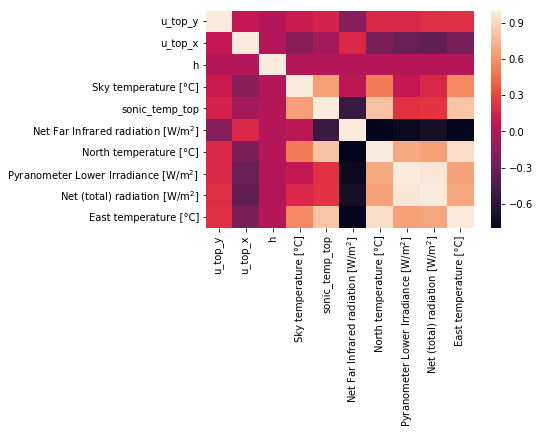

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:76: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Drop sonic_temp_top                 with p-value 0.296544


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Pyrgeometer Lower Irradiance [W/m$^2$] with p-value 0.00116689
eigenvalues are [1.80281687e+05 4.43216196e+04 3.75597136e+04 2.87114086e+04
 3.45926528e+04 1.65458152e+04 2.55868659e+03 1.01654576e+03
 3.33132269e+02 8.73850493e+00]
the condition number of the matrix is 143.6339947027616
the set of condition indices of the matrix are [  1.           2.01682398   2.19086023   2.50581242   2.28288415
   3.3008951    8.39396705  13.31718217  23.26309294 143.6339947 ]


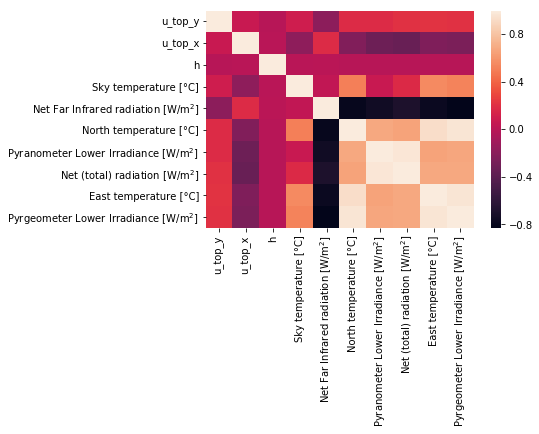

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Radiometer Ground temperature [°C] with p-value 0.00259041
eigenvalues are [2.12434609e+05 4.56119248e+04 3.76080908e+04 2.92100172e+04
 3.45927188e+04 1.69934146e+04 2.58622782e+03 1.11556572e+03
 3.33132343e+02 8.73591897e+00 2.85632993e+01]
the condition number of the matrix is 155.94028979084348
the set of condition indices of the matrix are [  1.           2.1581093    2.37668701   2.69678752   2.47810833
   3.53567476   9.06315163  13.79955413  25.25249163 155.94028979
  86.23994091]


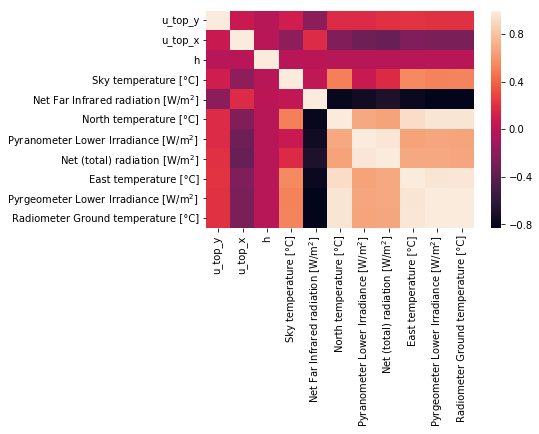

eigenvalues are [2.12434609e+05 4.56119248e+04 3.76080908e+04 2.92100172e+04
 3.45927188e+04 1.69934146e+04 2.58622782e+03 1.11556572e+03
 3.33132343e+02 8.73591897e+00 2.85632993e+01]
the condition number of the matrix is 155.94028979084348
the set of condition indices of the matrix are [  1.           2.1581093    2.37668701   2.69678752   2.47810833
   3.53567476   9.06315163  13.79955413  25.25249163 155.94028979
  86.23994091]


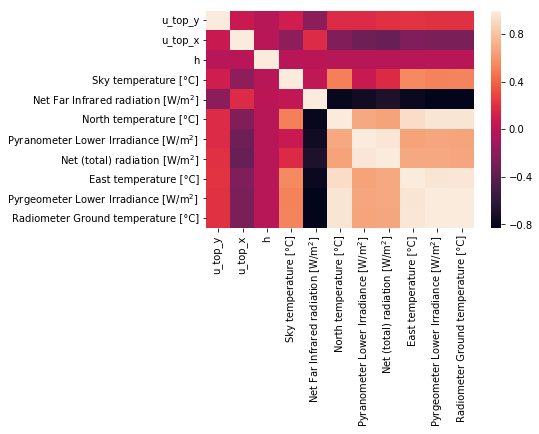

resulting features:
['u_top_y', 'u_top_x', 'h', 'Sky temperature [°C]', 'Net Far Infrared radiation [W/m$^2$]', 'North temperature [°C]', 'Pyranometer Lower Irradiance [W/m$^2$]', 'Net (total) radiation [W/m$^2$]', 'East temperature [°C]', 'Pyrgeometer Lower Irradiance [W/m$^2$]', 'Radiometer Ground temperature [°C]']


In [51]:
result = stepwise_selection(X_spring_tr_standard, y_spring_tr.iloc[:,1], initial_list=['u_top_y', 'u_top_x','h'])

print('resulting features:')
print(result)

### Summer

Perform the stepwise feature selection for x component of velocity u and visualize the correlation matrix at each iteration. The eigenvalues of the matrix are also visualized since they give an indication of the multicollinearity of the data as well as the condition number.

Add  Radiometer Ground temperature [°C] with p-value 0.0
eigenvalues are [75185.2043072  24960.00195018 44252.79718648 48153.99655614]
the condition number of the matrix is 1.7355769937730667
the set of condition indices of the matrix are [1.         1.73557699 1.30345436 1.2495396 ]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


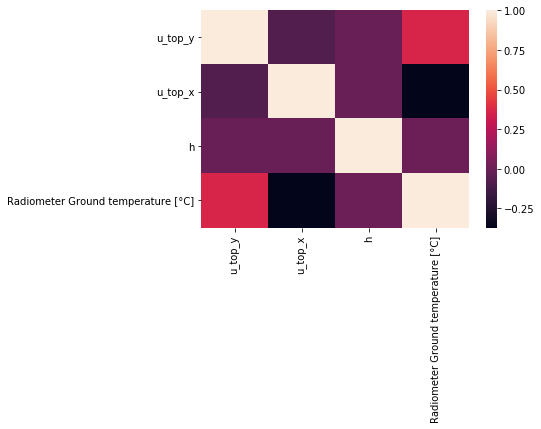

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:76: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Drop h                              with p-value 0.565724
Add  sonic_temp                     with p-value 1.24993e-209
eigenvalues are [104487.02229949   7319.73219171  36465.82514963  44279.42035918]
the condition number of the matrix is 3.778188140661675
the set of condition indices of the matrix are [1.         3.77818814 1.6927318  1.53613793]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


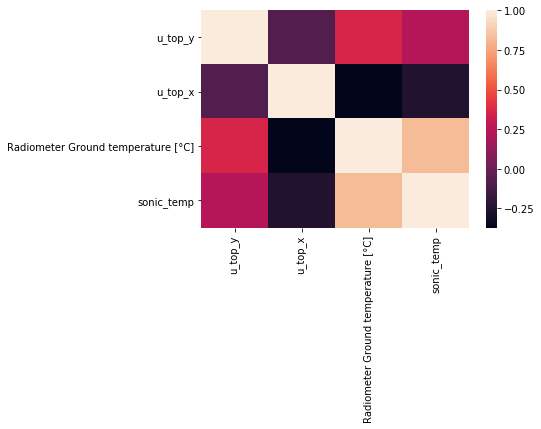

Add  South temperature [°C]         with p-value 2.65823e-67
eigenvalues are [147177.30730136  44285.09780793  39816.94505355   7561.99175617
   1848.658081  ]
the condition number of the matrix is 8.92261449883185
the set of condition indices of the matrix are [1.         1.82302079 1.92258902 4.41166297 8.9226145 ]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


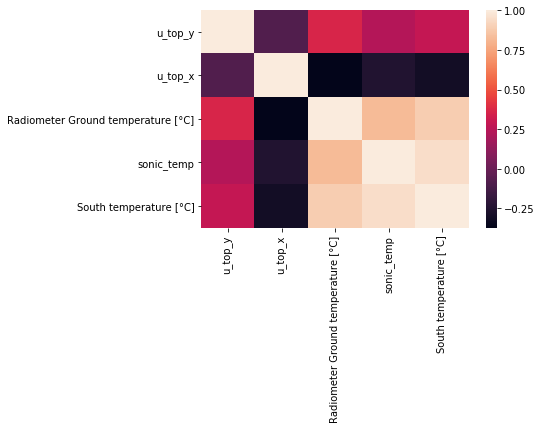

Add  u_top_z                        with p-value 1.65927e-28
eigenvalues are [148650.35264672  57490.12071773  40071.74508244  33542.6709627
   7254.110533     1819.00005741]
the condition number of the matrix is 9.039962221316433
the set of condition indices of the matrix are [1.         1.60800117 1.92603353 2.10515535 4.52679563 9.03996222]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


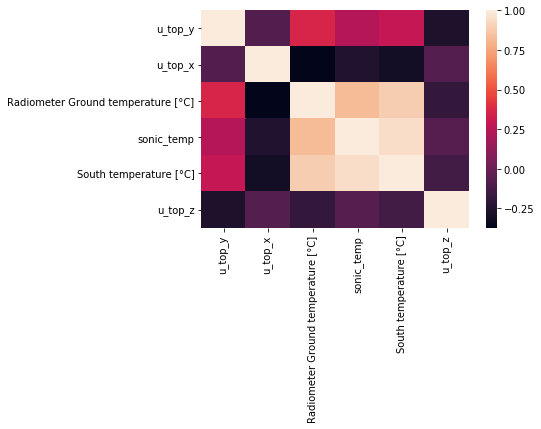

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  West temperature [°C]          with p-value 4.66029e-16
eigenvalues are [188441.0235059   57939.48960314  40215.64244014  33595.53507356
   8415.02085744   6649.25680561   1710.03171421]
the condition number of the matrix is 10.497494234080557
the set of condition indices of the matrix are [ 1.          1.80343459  2.16466264  2.36835579  4.73216772  5.323548
 10.49749423]


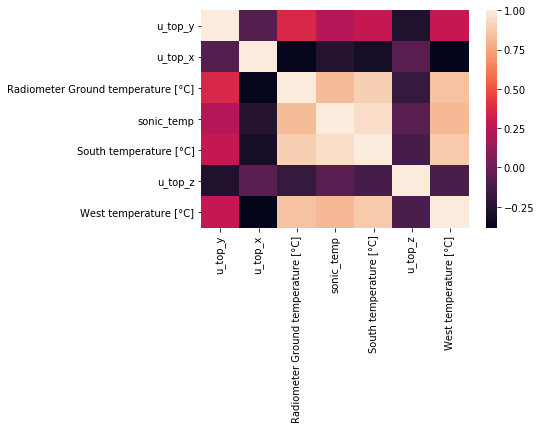

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Sky temperature [°C]           with p-value 1.37766e-10
eigenvalues are [213794.76476486  60371.19626542  41960.11368084  33742.22101399
  20040.57834902   1706.69732275   5813.09594974   7675.3326534 ]
the condition number of the matrix is 11.19232414848581
the set of condition indices of the matrix are [ 1.          1.8818441   2.25725282  2.51716509  3.26620476 11.19232415
  6.06449703  5.27776355]


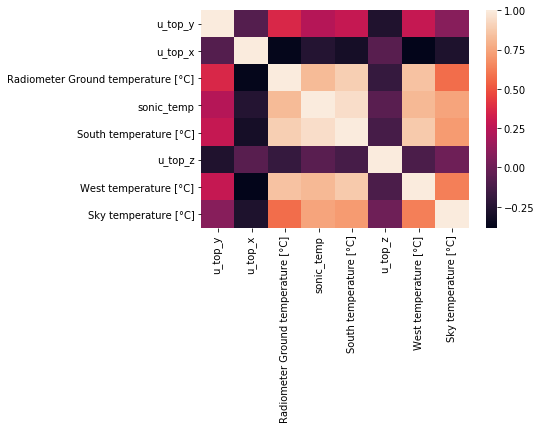

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Pyrgeometer Upper Irradiance [W/m$^2$] with p-value 1.23697e-06
eigenvalues are [2.44958352e+05 6.46598474e+04 4.49237170e+04 3.41049958e+04
 2.91147963e+04 5.97972613e+03 7.76203024e+03 1.70694919e+03
 3.15861273e+01]
the condition number of the matrix is 88.06390409833962
the set of condition indices of the matrix are [ 1.          1.94638517  2.33511506  2.68001439  2.90060938  6.40037586
  5.61769893 11.97942102 88.0639041 ]


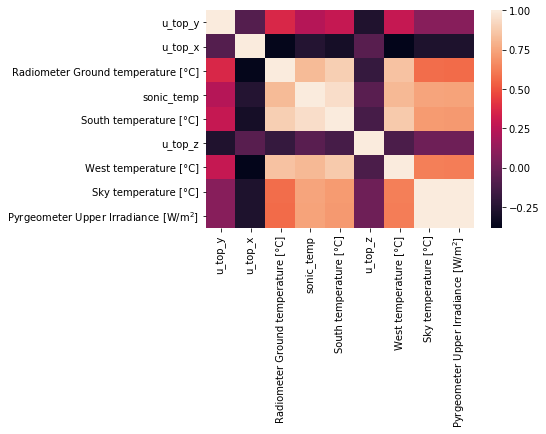

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  h                              with p-value 2.17161e-06
eigenvalues are [2.44961009e+05 6.46603542e+04 4.83860531e+04 4.48460138e+04
 3.40896008e+04 2.90984866e+04 3.15853938e+01 1.65247147e+03
 5.93922405e+03 7.71520125e+03]
the condition number of the matrix is 88.06540438617021
the set of condition indices of the matrix are [ 1.          1.9463881   2.25003038  2.33714985  2.68063401  2.90143791
 88.06540439 12.17535117  6.42219706  5.63475259]


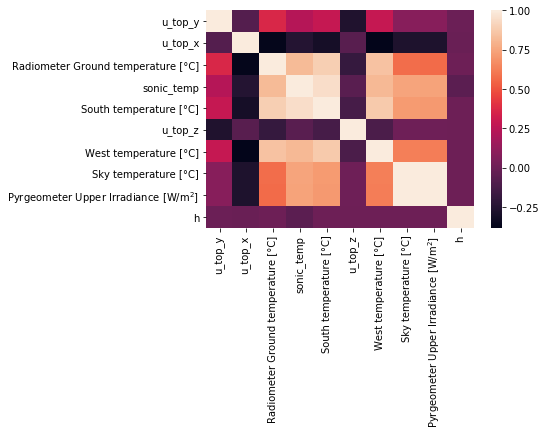

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  sonic_temp_top                 with p-value 5.22427e-10
eigenvalues are [2.86630012e+05 6.48317617e+04 4.84176122e+04 4.56550837e+04
 3.47958558e+04 2.99977881e+04 1.03764329e+04 6.55468330e+03
 1.91120265e+03 3.13769494e+01 3.16190979e+02]
the condition number of the matrix is 95.57745716182295
the set of condition indices of the matrix are [ 1.          2.10264967  2.43309545  2.50562607  2.87010027  3.09112249
  5.25577529  6.6127937  12.2463724  95.57745716 30.10829016]


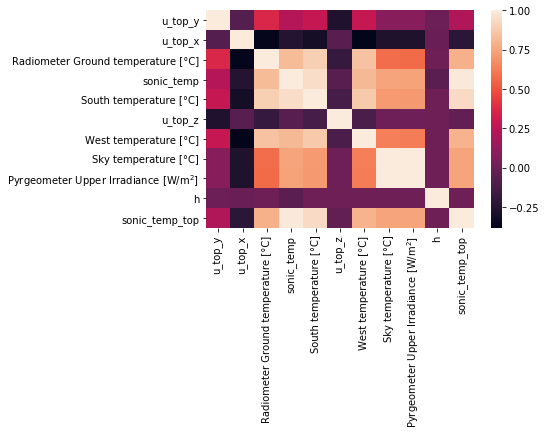

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Net (total) radiation [W/m$^2$] with p-value 1.14372e-05
eigenvalues are [3.00739860e+05 7.47950688e+04 5.27413017e+04 4.81860352e+04
 3.48594202e+04 3.14550861e+04 2.36397088e+04 6.93950838e+03
 3.12513663e+01 3.06876660e+02 2.07170763e+03 1.89017540e+03]
the condition number of the matrix is 98.09818948341821
the set of condition indices of the matrix are [ 1.          2.00520608  2.38792166  2.49824427  2.93721283  3.09207527
  3.56676449  6.58311049 98.09818948 31.30498982 12.04845231 12.6137565 ]


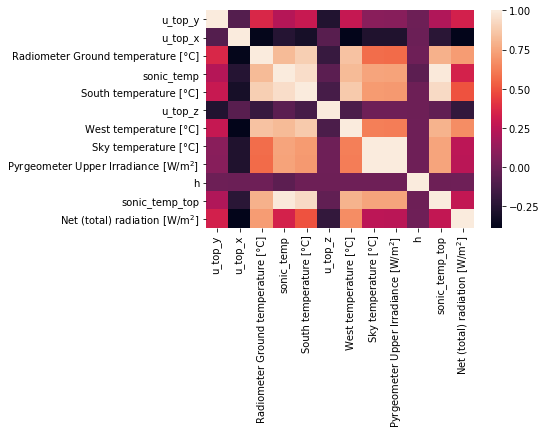

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Pyranometer Upper Irradiance [W/m$^2$] with p-value 0.000229074
eigenvalues are [3.19844267e+05 9.59565686e+04 5.57354494e+04 4.82410743e+04
 3.48656439e+04 3.36865505e+04 2.59248239e+04 7.10014864e+03
 2.16955283e+03 1.91432107e+03 3.07538278e+02 1.67156969e+01
 3.13463071e+01]
the condition number of the matrix is 138.32702633549235
the set of condition indices of the matrix are [  1.           1.82571057   2.39554058   2.57490256   3.02879891
   3.08134988   3.51245992   6.71174681  12.14183063  12.92593286
  32.24925571 138.32702634 101.01272642]


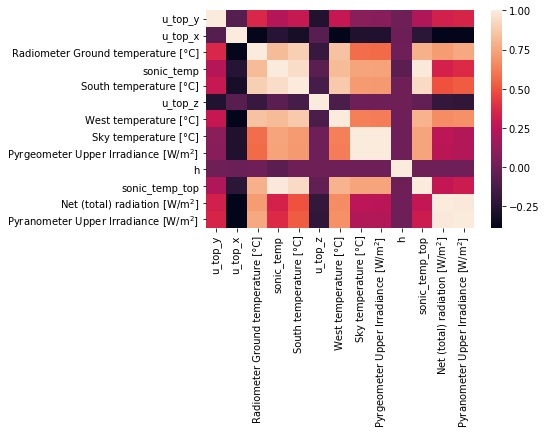

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  East temperature [°C]          with p-value 0.00214229
eigenvalues are [3.62523002e+05 9.69586577e+04 5.57923297e+04 4.82415552e+04
 3.49529897e+04 3.41542080e+04 2.60645333e+04 7.47673883e+03
 3.95852401e+03 1.92521650e+03 1.52901214e+03 3.07506981e+02
 1.66839723e+01 3.10415392e+01]
the condition number of the matrix is 147.40698204628885
the set of condition indices of the matrix are [  1.           1.93363495   2.54906281   2.74130358   3.22051717
   3.25795945   3.72943299   6.96324505   9.56976212  13.72233432
  15.39792914  34.33525636 147.40698205 108.06776269]


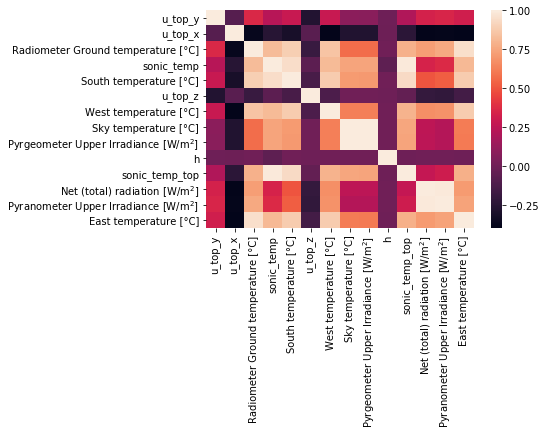

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  North temperature [°C]         with p-value 3.12359e-05
eigenvalues are [4.00790991e+05 9.92498075e+04 5.57930329e+04 4.82416688e+04
 3.45305483e+04 3.55665140e+04 2.63357532e+04 9.78278135e+03
 4.81918509e+03 3.80984667e+03 1.89266655e+03 9.15246035e+02
 3.01548294e+02 3.07723967e+01 9.63776673e+00]
the condition number of the matrix is 203.9251405399049
the set of condition indices of the matrix are [  1.           2.00952836   2.68021103   2.88235729   3.40688315
   3.35689939   3.9010912    6.40070486   9.11952403  10.2566427
  14.5519744   20.92618438  36.45696722 114.12434935 203.92514054]


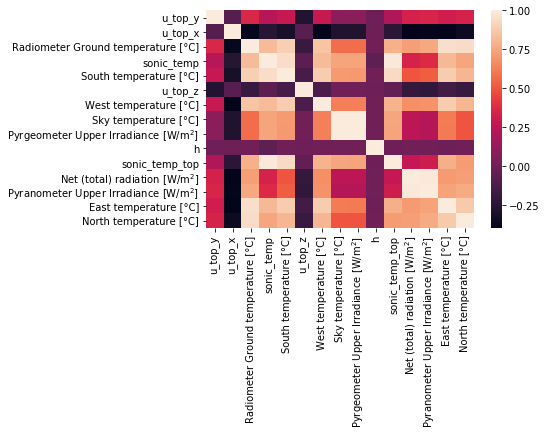

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Sensor Ground temperature [°C] with p-value 0.000820286
eigenvalues are [4.39464789e+05 9.93547391e+04 5.61221300e+04 4.82432409e+04
 3.45376822e+04 3.63016615e+04 2.74277196e+04 1.15912190e+04
 7.91707994e+03 3.81939910e+03 2.88020061e+03 1.74763473e+03
 4.58705726e+02 3.01404167e+02 3.07563517e+01 9.63770772e+00]
the condition number of the matrix is 213.53799792698635
the set of condition indices of the matrix are [  1.           2.10313789   2.79830449   3.01817074   3.56710134
   3.47935539   4.00283043   6.15740169   7.45039893  10.72666016
  12.35238084  15.85757263  30.95244505  38.18452705 119.53487531
 213.53799793]


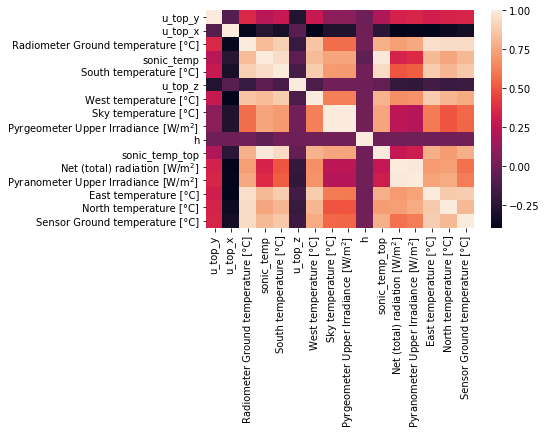

eigenvalues are [4.39464789e+05 9.93547391e+04 5.61221300e+04 4.82432409e+04
 3.45376822e+04 3.63016615e+04 2.74277196e+04 1.15912190e+04
 7.91707994e+03 3.81939910e+03 2.88020061e+03 1.74763473e+03
 4.58705726e+02 3.01404167e+02 3.07563517e+01 9.63770772e+00]
the condition number of the matrix is 213.53799792698635
the set of condition indices of the matrix are [  1.           2.10313789   2.79830449   3.01817074   3.56710134
   3.47935539   4.00283043   6.15740169   7.45039893  10.72666016
  12.35238084  15.85757263  30.95244505  38.18452705 119.53487531
 213.53799793]


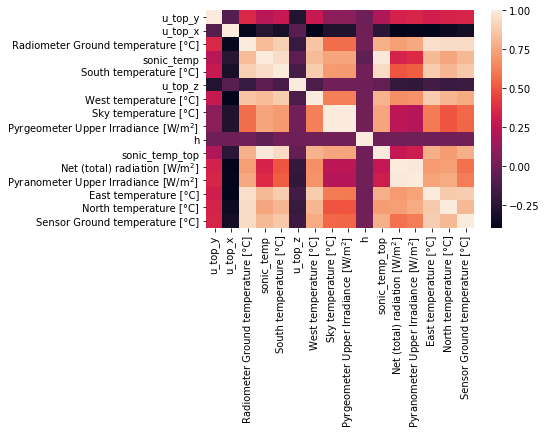

resulting features:
['u_top_y', 'u_top_x', 'Radiometer Ground temperature [°C]', 'sonic_temp', 'South temperature [°C]', 'u_top_z', 'West temperature [°C]', 'Sky temperature [°C]', 'Pyrgeometer Upper Irradiance [W/m$^2$]', 'h', 'sonic_temp_top', 'Net (total) radiation [W/m$^2$]', 'Pyranometer Upper Irradiance [W/m$^2$]', 'East temperature [°C]', 'North temperature [°C]', 'Sensor Ground temperature [°C]']


In [52]:
result = stepwise_selection(X_summer_tr_standard, y_summer_tr.iloc[:,0], initial_list=['u_top_y', 'u_top_x','h'])

print('resulting features:')
print(result)

Perform the stepwise feature selection for the y component of velocity of u and visualize the correlation matrix at each iteration. The eigenvalues of the matrix are also visualized since they give an indication of the multicollinearity of the data as well as the condition number.

Add  Pyrgeometer Upper Irradiance [W/m$^2$] with p-value 3.00676e-63
eigenvalues are [63414.63259186 35011.51028029 45975.43162313 48150.42550473]
the condition number of the matrix is 1.345827250486416
the set of condition indices of the matrix are [1.         1.34582725 1.1744427  1.14761093]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


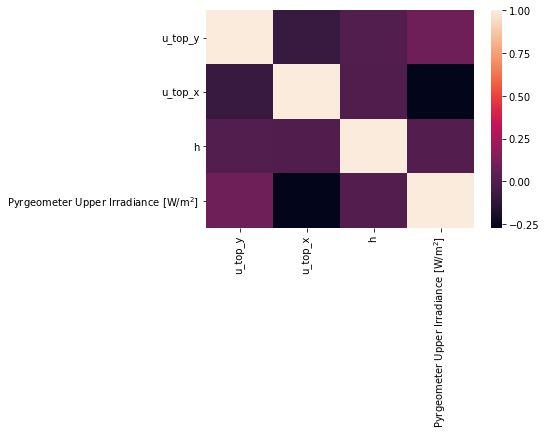

Add  Pyranometer Upper Irradiance [W/m$^2$] with p-value 1.63034e-06
eigenvalues are [83049.48390615 24947.58884331 36655.8881128  47767.37109072
 48269.66804702]
the condition number of the matrix is 1.8245433232811963
the set of condition indices of the matrix are [1.         1.82454332 1.50520827 1.31856881 1.31169032]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


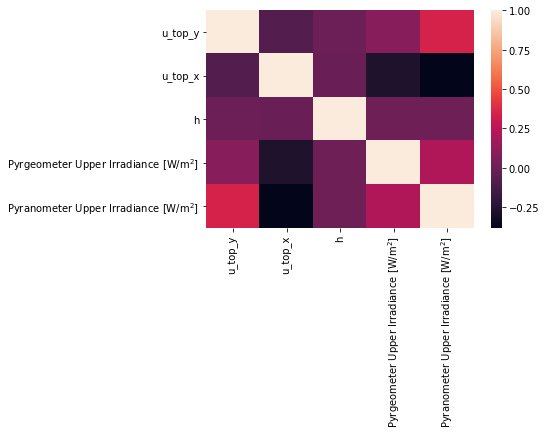

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  sonic_temp                     with p-value 0.00388025
eigenvalues are [109011.86538416  10829.72000451  25214.63742472  43115.54769563
  52418.09079212  48238.13869885]
the condition number of the matrix is 3.172694614797614
the set of condition indices of the matrix are [1.         3.17269461 2.07926825 1.5900835  1.44210302 1.50328601]


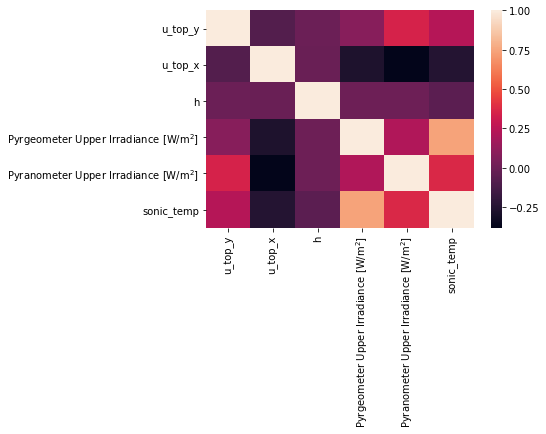

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  sonic_temp_top                 with p-value 5.51518e-153
eigenvalues are [146420.31637047  57549.29248228  44630.27892378  48288.14726189
  25231.84468755  14534.14474525    311.97552877]
the condition number of the matrix is 21.664087729944406
the set of condition indices of the matrix are [ 1.          1.59507341  1.81128116  1.74132726  2.40894103  3.17399275
 21.66408773]


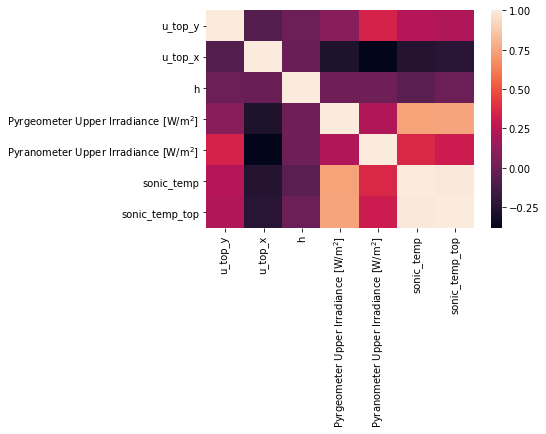

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  u_top_z                        with p-value 7.03443e-08
eigenvalues are [146966.99780068  66235.5784749     308.98126838  14494.51192516
  24539.04738674  33879.89507874  50708.08845734  47970.89960807]
the condition number of the matrix is 21.809405908598006
the set of condition indices of the matrix are [ 1.          1.48958141 21.80940591  3.18425701  2.44726535  2.08275834
  1.70243795  1.7503342 ]


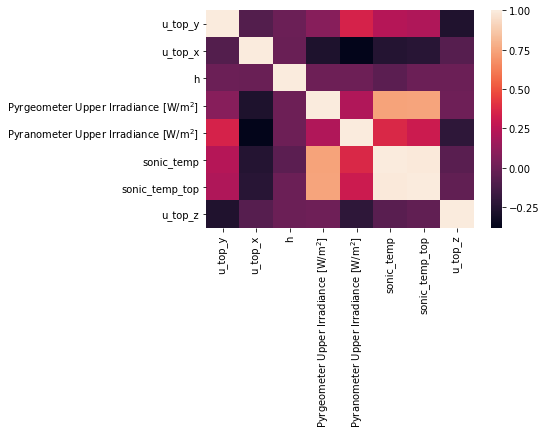

eigenvalues are [146966.99780068  66235.5784749     308.98126838  14494.51192516
  24539.04738674  33879.89507874  50708.08845734  47970.89960807]
the condition number of the matrix is 21.809405908598006
the set of condition indices of the matrix are [ 1.          1.48958141 21.80940591  3.18425701  2.44726535  2.08275834
  1.70243795  1.7503342 ]


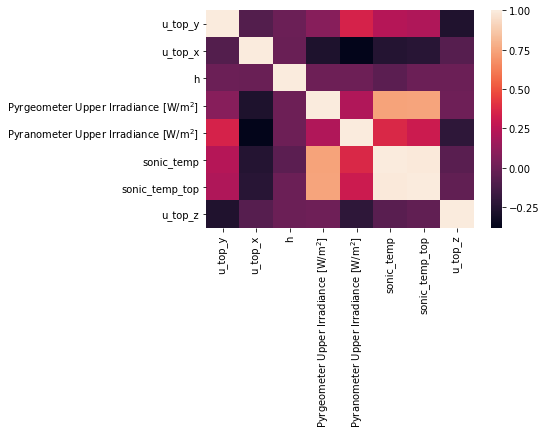

resulting features:
['u_top_y', 'u_top_x', 'h', 'Pyrgeometer Upper Irradiance [W/m$^2$]', 'Pyranometer Upper Irradiance [W/m$^2$]', 'sonic_temp', 'sonic_temp_top', 'u_top_z']


In [53]:
result = stepwise_selection(X_summer_tr_standard, y_summer_tr.iloc[:,1], initial_list=['u_top_y', 'u_top_x','h'])

print('resulting features:')
print(result)

### Winter

Perform the stepwise feature selection for the x component of velocity of u and visualize the correlation matrix at each iteration. The eigenvalues of the matrix are also visualized since they give an indication of the multicollinearity of the data as well as the condition number.

Add  Net Solar radiation [W/m$^2$]  with p-value 3.55438e-58
eigenvalues are [55888.04839708 22169.30126803 38546.21156149 38888.43877341]
the condition number of the matrix is 1.5877549287804216
the set of condition indices of the matrix are [1.         1.58775493 1.20411682 1.19880686]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


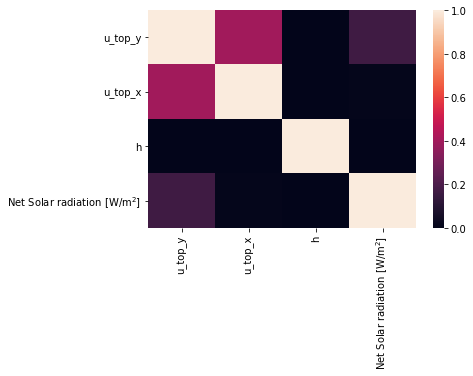

Add  sonic_temp                     with p-value 5.92245e-39
eigenvalues are [72234.84001746 22956.61135781 20496.8010005  39789.12371791
 38887.62390632]
the condition number of the matrix is 1.8772854550362923
the set of condition indices of the matrix are [1.         1.77386051 1.87728546 1.34738333 1.36291149]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


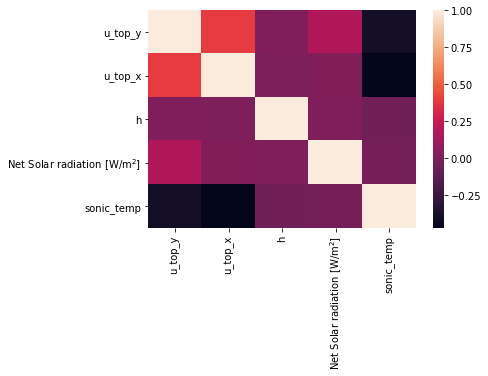

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Pyrgeometer Lower Irradiance [W/m$^2$] with p-value 1.5673e-45
eigenvalues are [91918.75232015  2426.53615813 52700.19571541 22079.7172216
 25171.20197128 38941.59661344]
the condition number of the matrix is 6.1547253378135025
the set of condition indices of the matrix are [1.         6.15472534 1.32067497 2.04035298 1.91095334 1.53636775]


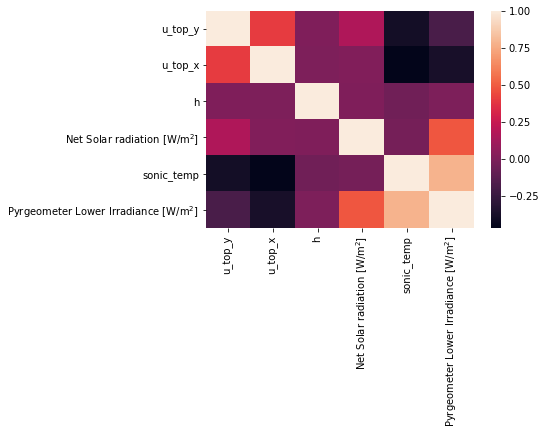

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  sonic_temp_top                 with p-value 7.31263e-06
eigenvalues are [124329.86798287  52854.87356524  38941.61283024  30390.65380952
  22116.14096278   3031.0324098     446.81843955]
the condition number of the matrix is 16.681004230089385
the set of condition indices of the matrix are [ 1.          1.53371695  1.78681985  2.02263592  2.37100823  6.40460642
 16.68100423]


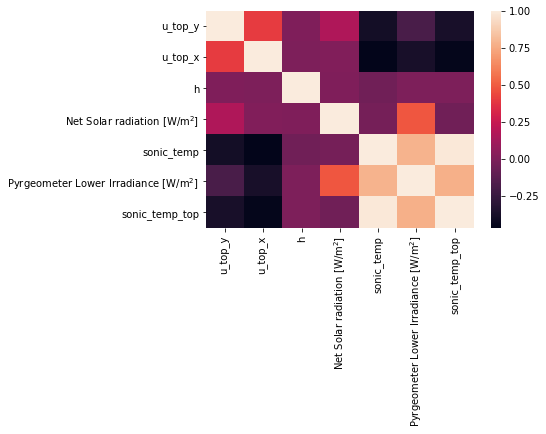

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:76: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Drop Net Solar radiation [W/m$^2$]  with p-value 0.208103


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  East temperature [°C]          with p-value 0.000269281
eigenvalues are [148844.53331301   1890.61776282    445.86151455  16893.92843854
  22886.03577895  42213.68493363  38936.33825851]
the condition number of the matrix is 18.27117389015795
the set of condition indices of the matrix are [ 1.          8.87287938 18.27117389  2.96825439  2.55024062  1.87775883
  1.95518966]


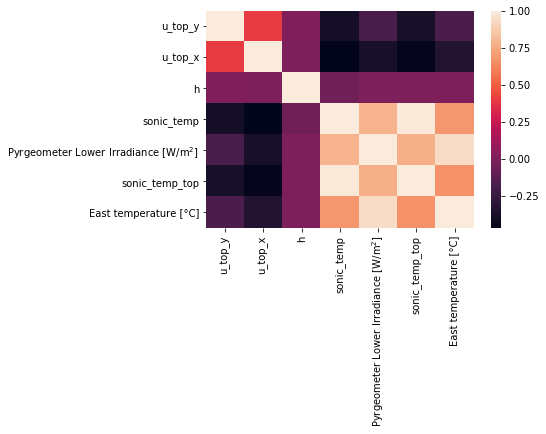

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  North temperature [°C]         with p-value 0.00134734
eigenvalues are [182497.29947728  43663.9048814   38939.98828708  22937.90744793
  16983.48735766   4729.96495126    786.6765589     444.77103849]
the condition number of the matrix is 20.256293036412313
the set of condition indices of the matrix are [ 1.          2.044405    2.16486248  2.82066379  3.27804405  6.21153962
 15.23105956 20.25629304]


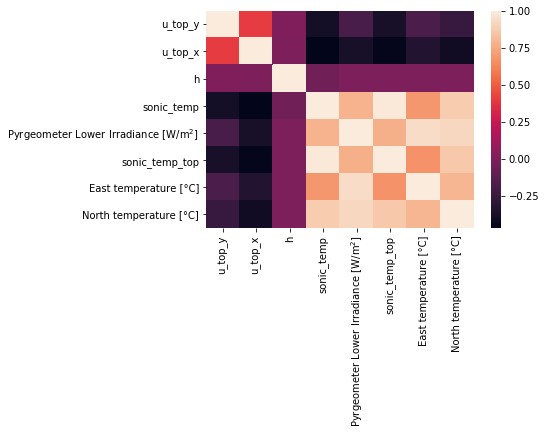

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Sensor Ground temperature [°C] with p-value 0.00459355
eigenvalues are [213117.56084139  44245.40606811  38939.99047154  23114.30538579
  18273.6367193    7128.66158757   3971.47439848    442.16064855
    623.80387927]
the condition number of the matrix is 21.95429897645956
the set of condition indices of the matrix are [ 1.          2.19470183  2.33943885  3.0364714   3.41505046  5.46771185
  7.32544033 21.95429898 18.48355835]


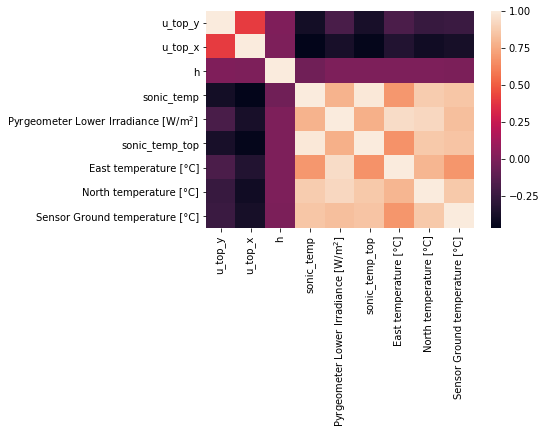

eigenvalues are [213117.56084139  44245.40606811  38939.99047154  23114.30538579
  18273.6367193    7128.66158757   3971.47439848    442.16064855
    623.80387927]
the condition number of the matrix is 21.95429897645956
the set of condition indices of the matrix are [ 1.          2.19470183  2.33943885  3.0364714   3.41505046  5.46771185
  7.32544033 21.95429898 18.48355835]


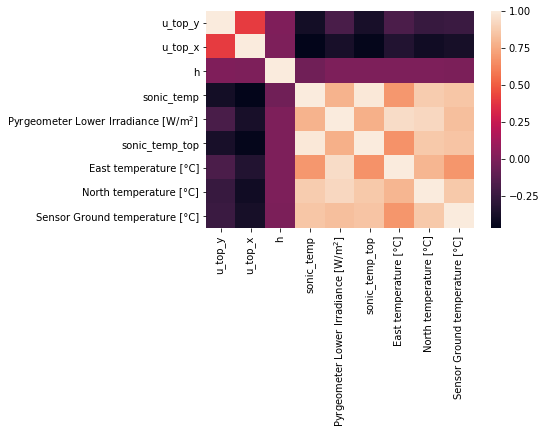

resulting features:
['u_top_y', 'u_top_x', 'h', 'sonic_temp', 'Pyrgeometer Lower Irradiance [W/m$^2$]', 'sonic_temp_top', 'East temperature [°C]', 'North temperature [°C]', 'Sensor Ground temperature [°C]']


In [54]:
result = stepwise_selection(X_winter_tr_standard, y_winter_tr.iloc[:,0], initial_list=['u_top_y', 'u_top_x','h'])

print('resulting features:')
print(result)

Perform the stepwise feature selection for the y component of velocity u and visualize the correlation matrix at each iteration. The eigenvalues of the matrix are also visualized since they give an indication of the multicollinearity of the data as well as the condition number.

Add  u_top_z                        with p-value 6.73822e-26
eigenvalues are [21970.12146297 54958.26782449 39705.57918948 38858.03152307]
the condition number of the matrix is 1.5816132298884318
the set of condition indices of the matrix are [1.58161323 1.         1.1764968  1.18925811]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


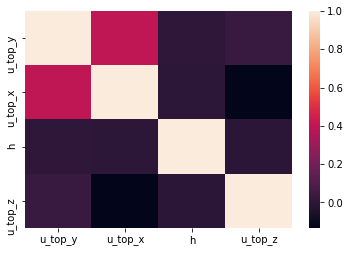

Add  sonic_temp                     with p-value 1.22286e-26
eigenvalues are [72472.65982603 22715.31914127 20516.08896177 39746.72695829
 38914.20511265]
the condition number of the matrix is 1.8794891093765371
the set of condition indices of the matrix are [1.         1.7861901  1.87948911 1.35031911 1.36468689]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


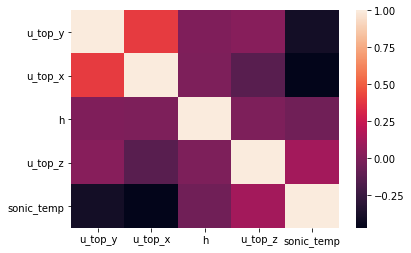

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Pyrgeometer Upper Irradiance [W/m$^2$] with p-value 5.76596e-05
eigenvalues are [92696.89531389 12334.45936977 22183.11206548 27328.02289243
 39776.00340152 38919.50695692]
the condition number of the matrix is 2.741400798516977
the set of condition indices of the matrix are [1.         2.7414008  2.04419046 1.84174071 1.52658863 1.54329493]


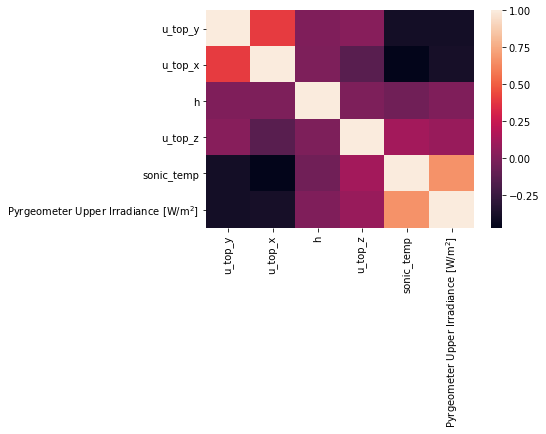

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Sky temperature [°C]           with p-value 6.27406e-19
eigenvalues are [1.22174584e+05 6.60430544e+01 1.49602780e+04 2.23062870e+04
 3.38489792e+04 3.98223295e+04 3.89324991e+04]
the condition number of the matrix is 43.01073452679943
the set of condition indices of the matrix are [ 1.         43.01073453  2.8577261   2.34032834  1.89984271  1.75156841
  1.771472  ]


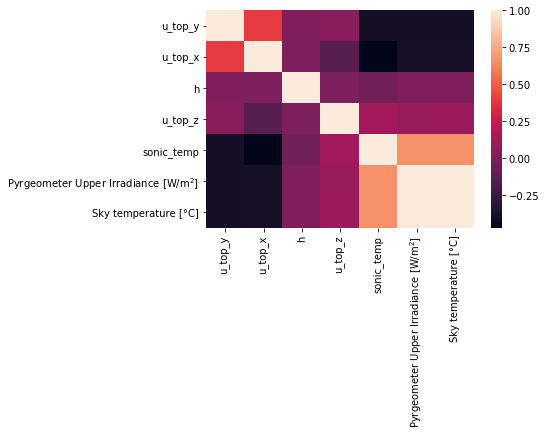

eigenvalues are [1.22174584e+05 6.60430544e+01 1.49602780e+04 2.23062870e+04
 3.38489792e+04 3.98223295e+04 3.89324991e+04]
the condition number of the matrix is 43.01073452679943
the set of condition indices of the matrix are [ 1.         43.01073453  2.8577261   2.34032834  1.89984271  1.75156841
  1.771472  ]


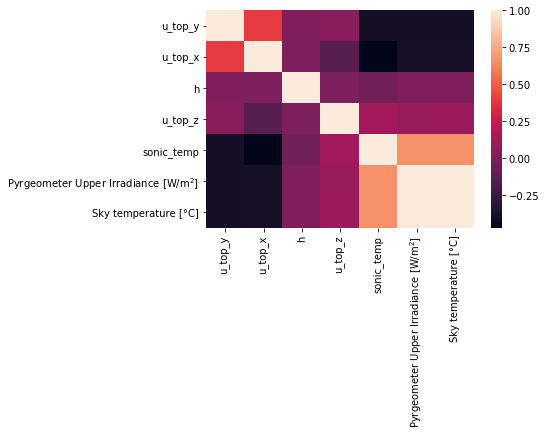

resulting features:
['u_top_y', 'u_top_x', 'h', 'u_top_z', 'sonic_temp', 'Pyrgeometer Upper Irradiance [W/m$^2$]', 'Sky temperature [°C]']


In [55]:
result = stepwise_selection(X_winter_tr_standard, y_winter_tr.iloc[:,1], initial_list=['u_top_y', 'u_top_x','h'])

print('resulting features:')
print(result)

### Autumn

Perform the stepwise feature selection for the x component of velocity of u and visualize the correlation matrix at each iteration. The eigenvalues of the matrix are also visualized since they give an indication of the multicollinearity of the data as well as the condition number.

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Pyranometer Lower Irradiance [W/m$^2$] with p-value 1.2576e-224
eigenvalues are [51244.11761165 28612.21069786 36759.73800804 38867.93368245]
the condition number of the matrix is 1.3382778883177904
the set of condition indices of the matrix are [1.         1.33827789 1.18068979 1.14822311]


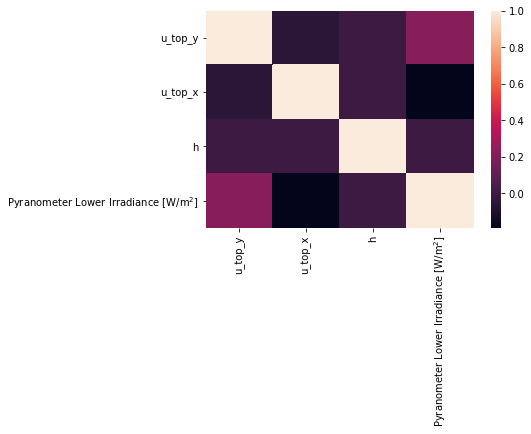

Add  u_top_z                        with p-value 7.10814e-78
eigenvalues are [52415.589289   27510.4232767  30820.99563445 44740.49305507
 38867.49874478]
the condition number of the matrix is 1.3803257827253417
the set of condition indices of the matrix are [1.         1.38032578 1.30408802 1.08238024 1.16127998]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


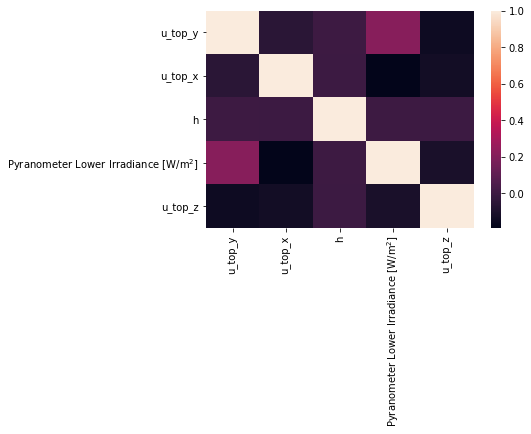

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Pyrgeometer Upper Irradiance [W/m$^2$] with p-value 9.89929e-35
eigenvalues are [52447.26348227 48367.23168694 26779.82144905 30798.99969611
 35954.33135687 38878.35232874]
the condition number of the matrix is 1.3994506172617056
the set of condition indices of the matrix are [1.         1.04132382 1.39945062 1.30494771 1.20777437 1.16146865]


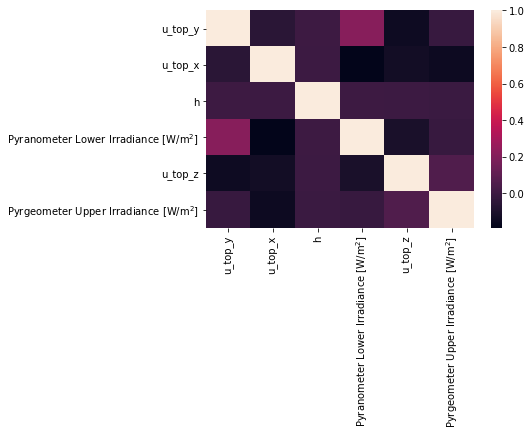

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Net Far Infrared radiation [W/m$^2$] with p-value 1.14009e-14
eigenvalues are [73978.32585916 11504.27825081 27358.60729127 31104.39329257
 48502.59973003 40779.78236243 38869.01321372]
the condition number of the matrix is 2.535844161706703
the set of condition indices of the matrix are [1.         2.53584416 1.64439163 1.54220243 1.23500791 1.34688277
 1.37959144]


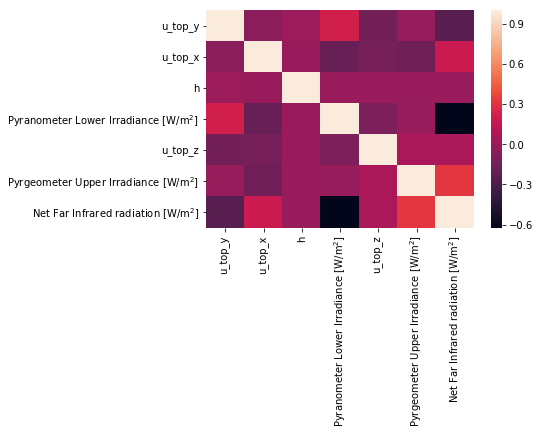

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  sonic_temp_top                 with p-value 5.42044e-70
eigenvalues are [84460.09509153  1610.55735597 57986.83528688 23207.33833334
 30865.60735024 32252.71510551 41715.69087935 38869.16059718]
the condition number of the matrix is 7.241652572574745
the set of condition indices of the matrix are [1.         7.24165257 1.20687163 1.90771334 1.65420134 1.61823892
 1.42290552 1.47408729]


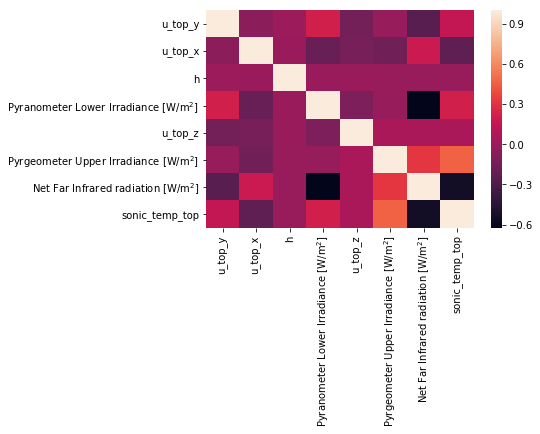

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  South temperature [°C]         with p-value 5.42091e-62
eigenvalues are [114947.70868842  62999.28642857    350.04347958   1615.20431305
  23632.88527847  42372.67090339  30888.92518354  34163.11384934
  38869.16187563]
the condition number of the matrix is 18.12129219684523
the set of condition indices of the matrix are [ 1.          1.35077292 18.1212922   8.43599719  2.20542242  1.64705173
  1.92907344  1.83430452  1.71967973]


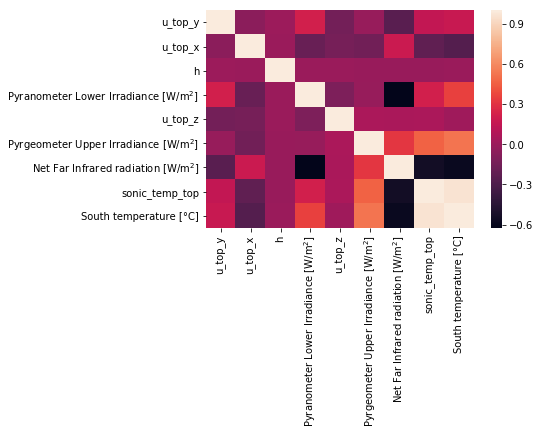

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:76: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Drop Pyranometer Lower Irradiance [W/m$^2$] with p-value 0.268612


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  North temperature [°C]         with p-value 4.51031e-20
eigenvalues are [142062.46276209  55550.42568452   4573.29740332    314.39679771
   1385.33425773  30104.38571171  34878.59802745  42101.67745892
  38868.42189655]
the condition number of the matrix is 21.256933440169565
the set of condition indices of the matrix are [ 1.          1.59917493  5.57346075 21.25693344 10.12657032  2.17232492
  2.01818122  1.83691885  1.91179453]


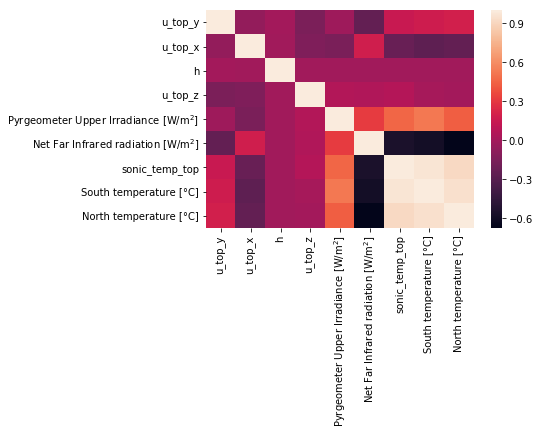

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  sonic_temp                     with p-value 4.52847e-12
eigenvalues are [178677.59243711  55759.78138621  30126.40381723  42154.12372919
  35356.47062589  38932.26373127   5774.28860987   1399.34666839
    319.181139      210.54785583]
the condition number of the matrix is 29.131284492169645
the set of condition indices of the matrix are [ 1.          1.79008855  2.43535008  2.05880405  2.24802219  2.14229965
  5.5627021  11.29984241 23.66009238 29.13128449]


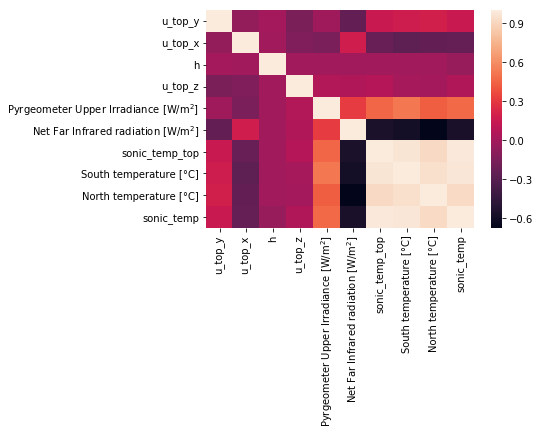

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  East temperature [°C]          with p-value 1.21693e-06
eigenvalues are [209786.05153873  56520.33079238  42204.73097386  30171.426548
  35357.52317999  38935.07942527  11022.4032517    2536.476332
    551.98204607    284.45613122    210.53978077]
the condition number of the matrix is 31.566121319014556
the set of condition indices of the matrix are [ 1.          1.92657516  2.22950133  2.6368801   2.43583231  2.32122785
  4.36264783  9.09437582 19.49511622 27.15692888 31.56612132]


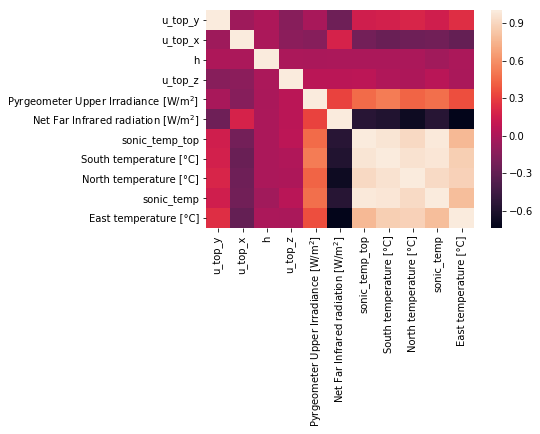

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Net (total) radiation [W/m$^2$] with p-value 3.19671e-11
eigenvalues are [2.18281627e+05 5.98413855e+04 2.90052713e+04 3.25062698e+04
 4.22138151e+04 4.01974683e+04 3.87345319e+04 2.89233726e+03
 1.81099052e+03 5.09722623e+02 2.07286383e+02 2.51294498e+02]
the condition number of the matrix is 32.450635334986835
the set of condition indices of the matrix are [ 1.          1.90988743  2.74327992  2.59134372  2.27395198  2.33028607
  2.37388368  8.6872861  10.97868948 20.69386617 32.45063533 29.47250845]


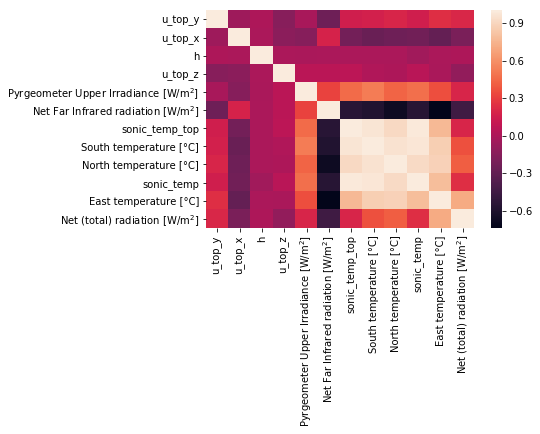

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Sensor Ground temperature [°C] with p-value 2.09764e-11
eigenvalues are [2.49026632e+05 5.99705398e+04 4.22252617e+04 4.10610036e+04
 3.88335027e+04 3.25609957e+04 2.90761132e+04 7.37880820e+03
 2.58926235e+03 1.76039561e+03 4.43024010e+02 1.83436807e+02
 2.14024132e+02]
the condition number of the matrix is 36.84509292179914
the set of condition indices of the matrix are [ 1.          2.03776415  2.42849226  2.46268076  2.53232601  2.76550253
  2.92654173  5.80938002  9.80697051 11.89372135 23.70878321 36.84509292
 34.11077021]


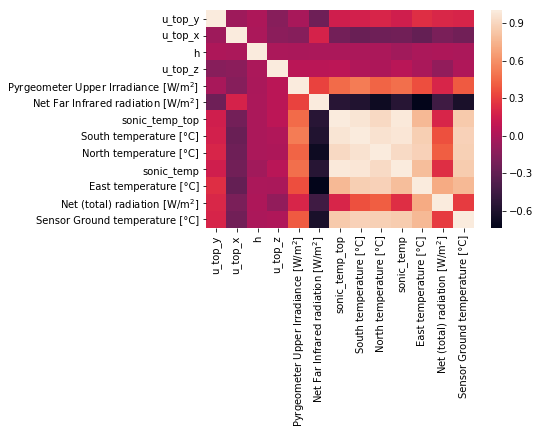

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Radiometer Ground temperature [°C] with p-value 8.3854e-06
eigenvalues are [2.86769102e+05 6.02010440e+04 4.22253890e+04 4.11176385e+04
 3.88336064e+04 3.27718750e+04 2.91208347e+04 7.43110416e+03
 2.83227855e+03 1.92632858e+03 1.81837609e+01 4.69076975e+02
 2.70771997e+02 2.06766714e+02]
the condition number of the matrix is 125.5811112585654
the set of condition indices of the matrix are [  1.           2.18254982   2.60602962   2.64090085   2.71745472
   2.95811827   3.13808186   6.21211524  10.06232166  12.20115638
 125.58111126  24.72544519  32.54350336  37.24138848]


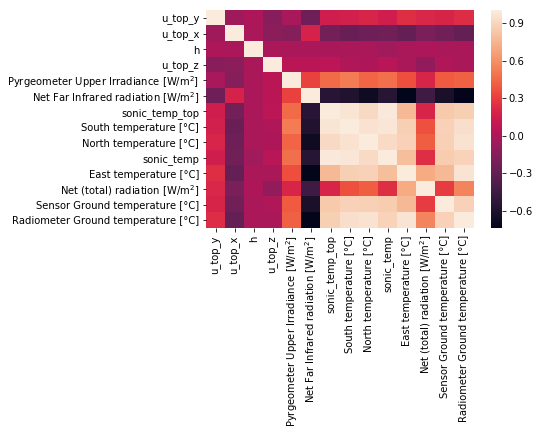

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  West temperature [°C]          with p-value 0.000892906
eigenvalues are [3.22728924e+05 6.02473390e+04 4.22809684e+04 4.12274744e+04
 3.88336512e+04 3.29141261e+04 2.91854811e+04 8.06891022e+03
 3.54600578e+03 1.96149020e+03 1.15242379e+03 1.81744059e+01
 4.37679065e+02 2.55619769e+02 2.06732256e+02]
the condition number of the matrix is 133.256632329765
the set of condition indices of the matrix are [  1.           2.31446176   2.76278114   2.79785743   2.88280212
   3.13132237   3.32533587   6.32428603   9.5400187   12.82702302
  16.7345037  133.25663233  27.15445295  35.5321696   39.51070904]


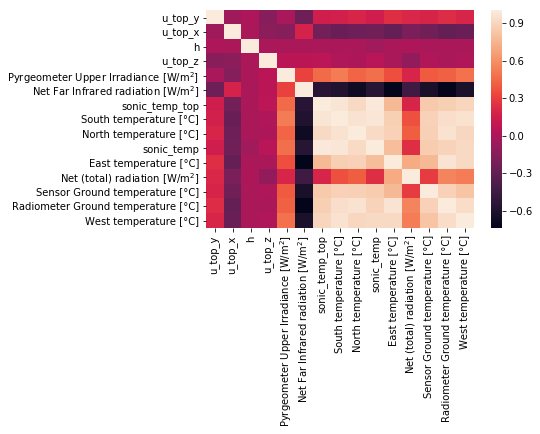

eigenvalues are [3.22728924e+05 6.02473390e+04 4.22809684e+04 4.12274744e+04
 3.88336512e+04 3.29141261e+04 2.91854811e+04 8.06891022e+03
 3.54600578e+03 1.96149020e+03 1.15242379e+03 1.81744059e+01
 4.37679065e+02 2.55619769e+02 2.06732256e+02]
the condition number of the matrix is 133.256632329765
the set of condition indices of the matrix are [  1.           2.31446176   2.76278114   2.79785743   2.88280212
   3.13132237   3.32533587   6.32428603   9.5400187   12.82702302
  16.7345037  133.25663233  27.15445295  35.5321696   39.51070904]


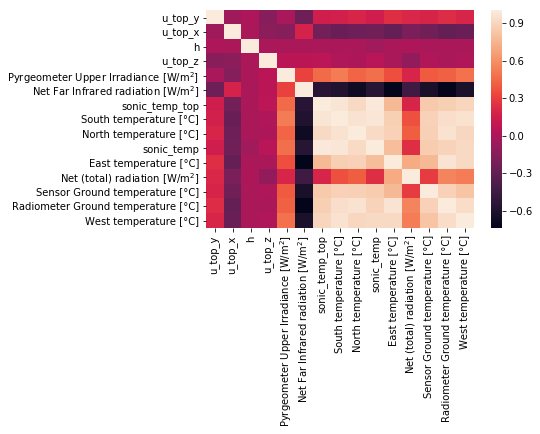

resulting features:
['u_top_y', 'u_top_x', 'h', 'u_top_z', 'Pyrgeometer Upper Irradiance [W/m$^2$]', 'Net Far Infrared radiation [W/m$^2$]', 'sonic_temp_top', 'South temperature [°C]', 'North temperature [°C]', 'sonic_temp', 'East temperature [°C]', 'Net (total) radiation [W/m$^2$]', 'Sensor Ground temperature [°C]', 'Radiometer Ground temperature [°C]', 'West temperature [°C]']


In [56]:
result = stepwise_selection(X_autumn_tr_standard, y_autumn_tr.iloc[:,0], initial_list=['u_top_y', 'u_top_x','h'])

print('resulting features:')
print(result)

Perform the stepwise feature selection for the y component of velocity u and visualize the correlation matrix at each iteration. The eigenvalues of the matrix are also visualized since they give an indication of the multicollinearity of the data as well as the condition number.

Add  Pyrgeometer Upper Irradiance [W/m$^2$] with p-value 3.82433e-36
eigenvalues are [32395.53832153 45018.83696411 39314.47909129 38755.14562306]
the condition number of the matrix is 1.1788391075930136
the set of condition indices of the matrix are [1.17883911 1.         1.0700914  1.07778578]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


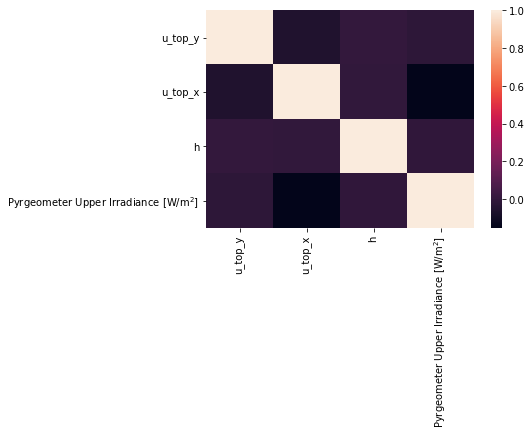

Add  Net (total) radiation [W/m$^2$] with p-value 1.14854e-14
eigenvalues are [55360.08694819 27230.07063743 32756.69647819 40177.49379938
 38830.6521368 ]
the condition number of the matrix is 1.4258505182121726
the set of condition indices of the matrix are [1.         1.42585052 1.30001491 1.17383475 1.19401846]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


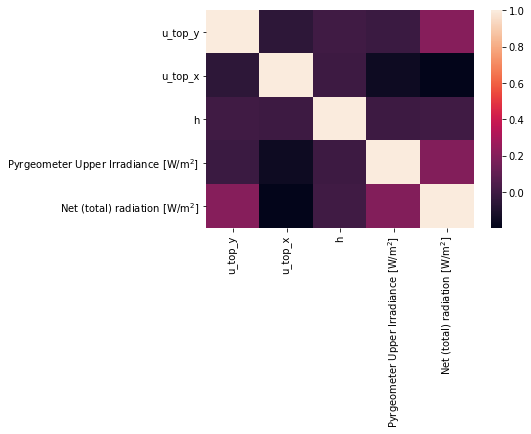

Add  North temperature [°C]         with p-value 5.55712e-14
eigenvalues are [74314.92220859 18592.2119903  27248.21191296 33838.01084884
 40401.48393593 38831.15910338]
the condition number of the matrix is 1.9992747563908455
the set of condition indices of the matrix are [1.         1.99927476 1.65146361 1.481957   1.35624876 1.38340021]


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


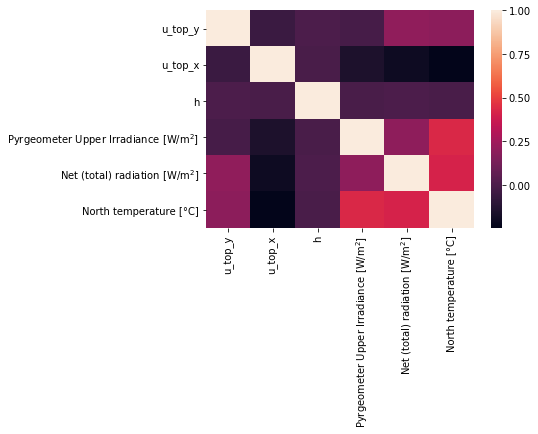

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Pyranometer Upper Irradiance [W/m$^2$] with p-value 3.50709e-36
eigenvalues are [1.00845381e+05 4.82733156e+01 1.86020331e+04 4.50396612e+04
 3.48857387e+04 3.38139796e+04 3.88619326e+04]
the condition number of the matrix is 45.70612909869852
the set of condition indices of the matrix are [ 1.         45.7061291   2.32834751  1.49634056  1.70021579  1.7269504
  1.61088972]


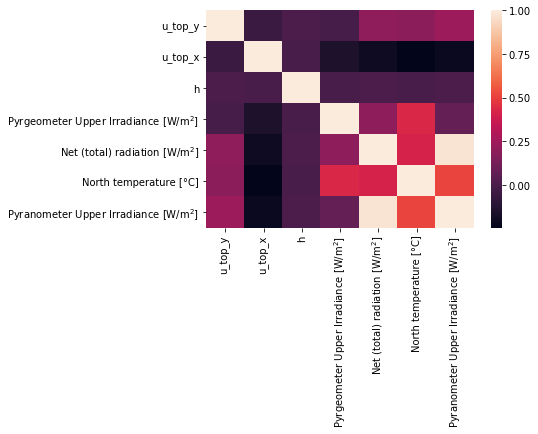

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  East temperature [°C]          with p-value 1.73524e-11
eigenvalues are [1.34357646e+05 1.91342774e+03 2.66548373e+01 2.13907943e+04
 4.53586818e+04 3.88619744e+04 3.48859297e+04 3.41728913e+04]
the condition number of the matrix is 70.99751946834937
the set of condition indices of the matrix are [ 1.          8.37963613 70.99751947  2.50621161  1.72107969  1.8593826
  1.96248363  1.98285214]


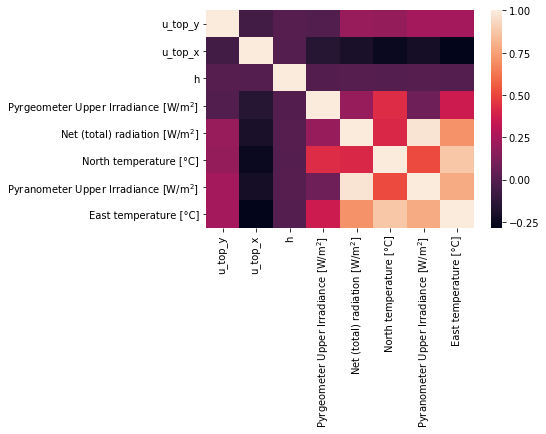

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  South temperature [°C]         with p-value 5.78652e-11
eigenvalues are [1.60587862e+05 5.24649172e+04 2.44141101e+04 3.43780522e+04
 3.60202690e+04 3.88668959e+04 2.05846260e+03 2.63219558e+01
 1.02210924e+03]
the condition number of the matrix is 78.10831689232
the set of condition indices of the matrix are [ 1.          1.74953189  2.56469608  2.16130334  2.11146011  2.0326679
  8.83252483 78.10831689 12.5345198 ]


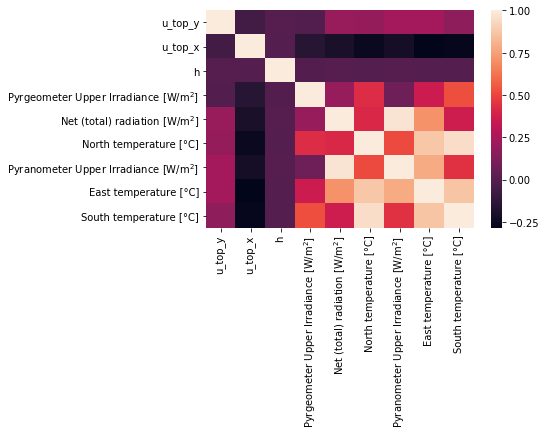

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  Sky temperature [°C]           with p-value 6.12514e-07
eigenvalues are [1.71480499e+05 7.18091417e+04 3.19789830e+04 3.88694655e+04
 3.60640534e+04 3.53518410e+04 2.05944381e+03 1.03353776e+03
 3.67409018e+01 2.62938822e+01]
the condition number of the matrix is 80.75696938387681
the set of condition indices of the matrix are [ 1.          1.54531671  2.31566134  2.1004052   2.18057034  2.20242613
  9.12498998 12.88084028 68.3175783  80.75696938]


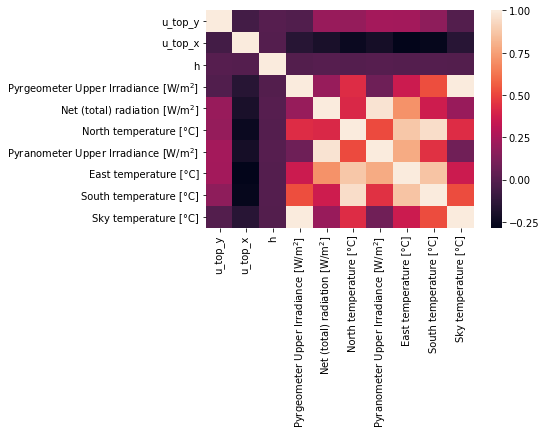

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  u_top_z                        with p-value 8.12656e-07
eigenvalues are [1.71486826e+05 7.33106054e+04 4.33098653e+04 2.94247544e+04
 3.22419468e+04 3.58129827e+04 3.88687862e+04 1.01480804e+03
 2.04778514e+03 3.65949257e+01 2.60452316e+01]
the condition number of the matrix is 81.14303910824702
the set of condition indices of the matrix are [ 1.          1.52943836  1.98985745  2.41412058  2.30624134  2.18824092
  2.1004623  12.9994037   9.15109761 68.45496398 81.14303911]


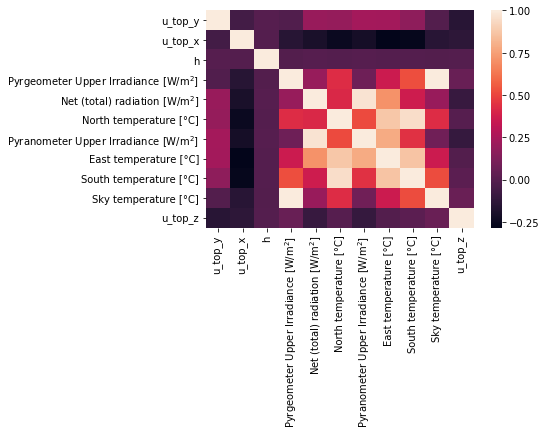

eigenvalues are [1.71486826e+05 7.33106054e+04 4.33098653e+04 2.94247544e+04
 3.22419468e+04 3.58129827e+04 3.88687862e+04 1.01480804e+03
 2.04778514e+03 3.65949257e+01 2.60452316e+01]
the condition number of the matrix is 81.14303910824702
the set of condition indices of the matrix are [ 1.          1.52943836  1.98985745  2.41412058  2.30624134  2.18824092
  2.1004623  12.9994037   9.15109761 68.45496398 81.14303911]


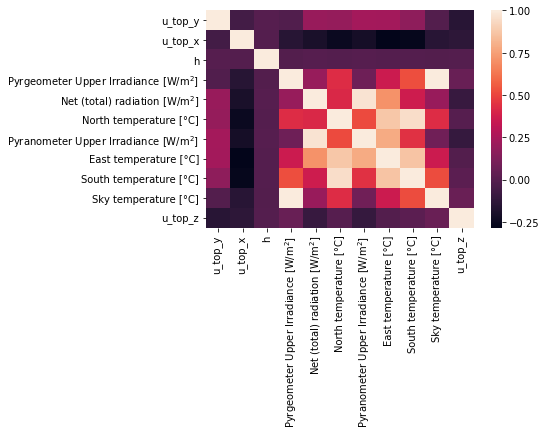

resulting features:
['u_top_y', 'u_top_x', 'h', 'Pyrgeometer Upper Irradiance [W/m$^2$]', 'Net (total) radiation [W/m$^2$]', 'North temperature [°C]', 'Pyranometer Upper Irradiance [W/m$^2$]', 'East temperature [°C]', 'South temperature [°C]', 'Sky temperature [°C]', 'u_top_z']


In [57]:
result = stepwise_selection(X_autumn_tr_standard, y_autumn_tr.iloc[:,1], initial_list=['u_top_y', 'u_top_x','h'])

print('resulting features:')
print(result)